# NYC MoMA Artworks - Exploratory Analysis

<section id="toc">
    <h2>Introduction</h2>
</section>

<section id="toc">
    <h2>Table of Contents</h2>
    <ol>
        <li><a href="#intro">Introduction</a></li>
        <li><a href="#load-libaries">Load Libraries</a></li>
        <li><a href="#define-funcs">Defining Data Analysis Functions</a></li>
        <li><a href="#load-data">Load Data</a></li>
        <li><a href="#data-prep">Data Preprocessing</li>
        <li><a href="#data-valid">Data Validation</a></li>
        <li><a href="#desc-stats">Define Data Quality</a></li>
        <li><a href="#ts-analysis">Collections Time Series Analysis</li>
            <ul>
            <li><a href="#acc-and-ts">Time Series Analysis & Decomposition of Acquisition Count</a>
            </ul>
        <li><a href="#gap-analysis">Collections Spatial Analysis</a></li>
        <li><a href="#conclusions">Conclusions & Recommendations</a></li>
    </ol>
</section>

<section id="load-libaries">
    <h2>Load Libraries</h2> 
</section>

In [135]:
import warnings  # program error handling
import os  # file-handling
import pandas as pd  # data-manipulation
import numpy as np # data-manipulation
import seaborn as sns # data-visualization
import matplotlib.pyplot as plt # data-visualization
from etl import ensure_dataset_types  # data-type enforcement
import statsmodels.api as sm  # time series analysis: seasonal decomposition


sns.set_style("whitegrid")
pd.set_option("display.float_format", "{:0.3f}".format)
warnings.simplefilter(action = "ignore", category = Warning)

<section id="define-funcs">
    <h2>Data Analysis Functions</h2>
</section>

In [136]:
def counts_by(column_names: str|list[str], df):
    return df[column_names].value_counts()


def detect_IQR_outliers(dataset, lower = 0.25, upper = 0.75):
    """Detects values that lie outsides of the specified IQR range."""
    Q1 = dataset.quantile(lower)
    Q3 = dataset.quantile(upper)
    IQR = Q3 - Q1
    lower_outliers = Q1 - (1.5 * IQR)
    upper_outliers = Q3 + (1.5 * IQR)
    outliers = dataset[~((lower_outliers > dataset) | (dataset < upper_outliers))]
    
    if not outliers.any().any():
        print("There are no outliers detected in the dataset.")
    else:
        print("Columns which contain outliers outside of the 25th and 75th percentiles:")
        print(outliers.any())
        return outliers


def remove_outliers(dataset, lower = 0.25, upper = 0.75):
    # Remove numerical outliers from the dataset
    dataset.astype(np.float64)
    Q1 = dataset.quantile(lower)
    Q3 = dataset.quantile(upper)
    IQR = Q3 - Q1
    lower_outliers = Q1 - (1.5 * IQR)
    upper_outliers = Q3 + (1.5 * IQR)

    return dataset[(dataset > lower_outliers) & (dataset < upper_outliers)]


def gen_ts_features(df, date_column, more_columns):
    # Generates Time Series Features based on date_column
    # Makes for easier analysis of operational (day-to-day) processes.
    out = df[[date_column] + more_columns].copy()
    out[date_column] = pd.to_datetime(out[date_column], format = "%m/%d/%Y", errors = "coerce")
    weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

    out["weekday"] = pd.Categorical(out[date_column].dt.day_name(), categories = weekday_order, ordered = True)
    out["day_of_month"] = out[date_column].dt.day.astype(int)
    out["day_of_year"] = out[date_column].dt.dayofyear.astype(int)
    out["week_of_month"] = (out[date_column].dt.day / 7).apply(lambda x: np.ceil(x)).astype(int)
    out["week"] = out[date_column].dt.isocalendar().week.astype(int)
    out["month"] = out[date_column].dt.month.astype(int)
    out["year"] = out[date_column].dt.isocalendar().year.astype(int)
    return out


def calculate_confidence_intervals_95(df: pd.DataFrame, column: str) -> tuple[float, float]:
    valid_data = df[~np.isnan(df[column])]
    # Calculate mean and 95% CI
    mean = valid_data[column].mean()
    std_err = valid_data[column].std() / np.sqrt(valid_data.shape[0])  # Standard error calculation
    lower_bound, upper_bound = (mean - 1.96 * std_err, mean + 1.96 * std_err)  # CI calculation
    return lower_bound, upper_bound

<section id="load-data">
    <h2>Load all data</h2>
</section>

In [137]:
# Load in Dataset(s)
file_path = os.path.join("./out/datasets", "NYC-MoMA-storage_group-fill.csv")
artworks_df = ensure_dataset_types(pd.read_csv(file_path, index_col=[0]))

<section id="#data-prep">
    <h2>Data Preprocessing</h2>
</section>

In [200]:
# SCAFFOLDING: Sampling to 15k points for speed-of-dev.
# SCAFFOLDING: Will remove when polishing.

# Data Preprocessing
artworks_df = artworks_df.sort_values(by=["acquisition_date", "object_number"])

# Calculate the range for the last 30 years
latest_30_years = artworks_df["acquisition_date"].max() - pd.DateOffset(years=30)

# Final datasets for analysis
datasets = dict(
    artworks_data = artworks_df.copy(),
    recent_data = artworks_df[latest_30_years <= artworks_df["acquisition_date"]].copy()
)

datasets["artworks_tsdata"] = gen_ts_features(datasets["artworks_data"],
                                            "acquisition_date", 
                                            ["date", "department", "credit_group", "storage_group", "height_ft",
                                             "width_ft", "depth_ft", "cubic_ft", "spatial_running_total", 
                                             "adate_sum", "acc_gaps"])

datasets["recent_tsdata"] = gen_ts_features(datasets["recent_data"],
                                            "acquisition_date", 
                                            ["date", "department", "credit_group", "storage_group", "height_ft",
                                             "width_ft", "depth_ft", "cubic_ft", "spatial_running_total", 
                                             "adate_sum", "acc_gaps"])

# datasets["artworks_data"].loc[:, "acc_gaps"] = datasets["artworks_data"]["acc_gaps"].apply(lambda x: np.abs(pd.Timedelta(x).days))
# datasets["artworks_tsdata"].loc[:, "acc_gaps"] = datasets["artworks_tsdata"]["acc_gaps"].apply(lambda x: np.abs(pd.Timedelta(x).days))
# datasets["recent_data"].loc[:, "acc_gaps"] = datasets["recent_data"]["acc_gaps"].apply(lambda x: np.abs(pd.Timedelta(x).days))
# datasets["recent_data"].loc[:, "acc_gaps"] = datasets["recent_tsdata"]["acc_gaps"].apply(lambda x: np.abs(pd.Timedelta(x).days))

categorical_columns = datasets["artworks_data"].select_dtypes(include=["object", "category", "datetime64[ns]"]).columns
numerical_columns = datasets["artworks_data"].select_dtypes(exclude=["object", "category", "datetime64[ns]"]).columns
spatial_columns = [
    "height_ft",
    "width_ft",
    "depth_ft",
    "cubic_ft",
    "spatial_running_total",
]
# Point-of-Interest 
# Categorical columns which are most relevant for inventory analysis + forecasting
hue_categories = ["credit_group", "department",  "storage_group"]


<section id="data-valid">
    <h2>Data Validation</h2>
</section>

In [201]:
datasets["artworks_data"].info()

<class 'pandas.core.frame.DataFrame'>
Index: 130262 entries, 55947 to 129943
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   date                   126810 non-null  datetime64[ns]
 1   acquisition_date       130262 non-null  datetime64[ns]
 2   credit                 127192 non-null  object        
 3   department             130262 non-null  object        
 4   classification         130262 non-null  object        
 5   object_number          130262 non-null  object        
 6   credit_group           130262 non-null  object        
 7   storage_group          130262 non-null  object        
 8   height_ft              130262 non-null  float64       
 9   width_ft               130262 non-null  float64       
 10  depth_ft               130262 non-null  float64       
 11  cubic_ft               130262 non-null  float64       
 12  spatial_running_total  130262 non-null  float

In [202]:
datasets["recent_data"].info()

<class 'pandas.core.frame.DataFrame'>
Index: 62128 entries, 49649 to 129943
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   59633 non-null  datetime64[ns]
 1   acquisition_date       62128 non-null  datetime64[ns]
 2   credit                 61286 non-null  object        
 3   department             62128 non-null  object        
 4   classification         62128 non-null  object        
 5   object_number          62128 non-null  object        
 6   credit_group           62128 non-null  object        
 7   storage_group          62128 non-null  object        
 8   height_ft              62128 non-null  float64       
 9   width_ft               62128 non-null  float64       
 10  depth_ft               62128 non-null  float64       
 11  cubic_ft               62128 non-null  float64       
 12  spatial_running_total  62128 non-null  float64       
 13  a

In [203]:
datasets["artworks_data"].head()

date acquisition_date                 credit  \
55947 1914-01-01       1929-11-19  Gift of Paul J. Sachs   
55999 1923-01-01       1929-11-19  Gift of Paul J. Sachs   
56011 1922-01-01       1929-11-19  Gift of Paul J. Sachs   
56012 1923-01-01       1929-11-19      Given anonymously   
31549 1926-01-01       1929-11-19  Gift of Paul J. Sachs   

                       department classification object_number credit_group  \
55947  Prints & Illustrated Books          Print        1.1929         Gift   
55999  Prints & Illustrated Books          Print        2.1929         Gift   
56011  Prints & Illustrated Books          Print        3.1929         Gift   
56012  Prints & Illustrated Books          Print        3.1931         Gift   
31549                    Drawings        Drawing        4.1929         Gift   

        storage_group  height_ft  width_ft  depth_ft  cubic_ft  \
55947  Works on Paper      7.833     0.581     0.077     0.352   
55999  Works on Paper      0.745     0.571     0.077     0.033   
56011  Works on Paper      1.486     1.204     0.077     0.138   
56012  Works on Paper      1.424     0.886     0.077     0.098   
31549  Works on Paper      2.250     1.760     0.077     0.306   

       spatial_running_total  adate_sum acc_gaps  
55947             532853.711         10   0 days  
55999             532853.359         10   0 days  
56011             532853.326         10   0 days  
56012             532853.188         10   0 days  
31549             532853.090         10   0 days

In [204]:
datasets["recent_data"].head()

date acquisition_date  \
49649 1890-01-01       1986-12-18   
49667 1850-01-01       1986-12-18   
49684 1933-01-01       1986-12-18   
49702 1984-01-01       1986-12-18   
49742 1929-01-01       1986-12-18   

                                                  credit   department  \
49649                                  Gift of Paul Katz  Photography   
49667  Acquired through the generosity of Blanchette ...  Photography   
49684                         Lois and Bruce Zenkel Fund  Photography   
49702              Gift of Mr. and Mrs. Barnabas McHenry  Photography   
49742                               Gift of Bernard Leeb  Photography   

      classification object_number credit_group storage_group  height_ft  \
49649     Photograph      400.1986         Gift         Photo      0.705   
49667     Photograph      401.1986        Other         Photo      0.692   
49684     Photograph      402.1986         Fund         Photo      0.827   
49702     Photograph      403.1986         Gift         Photo      1.099   
49742     Photograph      404.1986         Gift         Photo      0.607   

       width_ft  depth_ft  cubic_ft  spatial_running_total  adate_sum acc_gaps  
49649     0.554     0.143     0.056             314997.614         38   0 days  
49667     0.400     0.143     0.039             314997.558         38   0 days  
49684     1.237     0.143     0.146             314997.519         38   0 days  
49702     1.404     0.143     0.220             314997.373         38   0 days  
49742     0.768     0.143     0.066             314997.153         38   0 days

In [205]:
datasets["artworks_data"].tail()

date acquisition_date  \
130193 2013-01-01       2016-12-15   
128295 2013-01-01       2016-12-15   
129942 2014-01-01       2016-12-15   
118992 1971-01-01       2016-12-15   
129943 2005-01-01       2016-12-15   

                                                   credit  \
130193  Committee on Media and Performance Art and Pau...   
128295                                 Gift of Paul Leong   
129942                                 Gift of the artist   
118992                              Gift of Virginia Dwan   
129943                      The Contemporary Arts Council   

                       department classification  object_number credit_group  \
130193  Media and Performance Art    Performance  1351.2016.1-2        Other   
128295  Media and Performance Art  Work on Paper    1351.2016.2         Gift   
129942  Media and Performance Art          Video      1352.2016         Gift   
118992  Media and Performance Art          Video      1353.2016         Gift   
129943  Media and Performance Art          Video      1354.2016        Other   

         storage_group  height_ft  width_ft  depth_ft  cubic_ft  \
130193      Time-based      0.577     0.563     0.033     0.011   
128295  Works on Paper      1.366     1.340     0.077     0.142   
129942      Time-based      0.577     0.563     0.033     0.011   
118992      Time-based      0.577     0.563     0.033     0.011   
129943      Time-based      0.577     0.563     0.033     0.011   

        spatial_running_total  adate_sum acc_gaps  
130193                  0.184          8   0 days  
128295                  0.173          8   0 days  
129942                  0.032          8   0 days  
118992                  0.021          8   0 days  
129943                  0.011          8      NaN

In [206]:
datasets["recent_data"].tail()

date acquisition_date  \
130193 2013-01-01       2016-12-15   
128295 2013-01-01       2016-12-15   
129942 2014-01-01       2016-12-15   
118992 1971-01-01       2016-12-15   
129943 2005-01-01       2016-12-15   

                                                   credit  \
130193  Committee on Media and Performance Art and Pau...   
128295                                 Gift of Paul Leong   
129942                                 Gift of the artist   
118992                              Gift of Virginia Dwan   
129943                      The Contemporary Arts Council   

                       department classification  object_number credit_group  \
130193  Media and Performance Art    Performance  1351.2016.1-2        Other   
128295  Media and Performance Art  Work on Paper    1351.2016.2         Gift   
129942  Media and Performance Art          Video      1352.2016         Gift   
118992  Media and Performance Art          Video      1353.2016         Gift   
129943  Media and Performance Art          Video      1354.2016        Other   

         storage_group  height_ft  width_ft  depth_ft  cubic_ft  \
130193      Time-based      0.577     0.563     0.033     0.011   
128295  Works on Paper      1.366     1.340     0.077     0.142   
129942      Time-based      0.577     0.563     0.033     0.011   
118992      Time-based      0.577     0.563     0.033     0.011   
129943      Time-based      0.577     0.563     0.033     0.011   

        spatial_running_total  adate_sum acc_gaps  
130193                  0.184          8   0 days  
128295                  0.173          8   0 days  
129942                  0.032          8   0 days  
118992                  0.021          8   0 days  
129943                  0.011          8      NaN

In [207]:
datasets["artworks_data"].isna().sum()

date                     3452
acquisition_date            0
credit                   3070
department                  0
classification              0
object_number               0
credit_group                0
storage_group               0
height_ft                   0
width_ft                    0
depth_ft                    0
cubic_ft                    0
spatial_running_total       0
adate_sum                   0
acc_gaps                    1
dtype: int64

In [208]:
datasets["recent_data"].isna().sum()

date                     2495
acquisition_date            0
credit                    842
department                  0
classification              0
object_number               0
credit_group                0
storage_group               0
height_ft                   0
width_ft                    0
depth_ft                    0
cubic_ft                    0
spatial_running_total       0
adate_sum                   0
acc_gaps                    1
dtype: int64

## Descriptive Statistics

In [209]:
print("Overall Collections Analysis Dataset Columns\n")
print("Categorical Columns:\n", list(categorical_columns), "\n")
print("Numerical Columns:\n", list(numerical_columns))

print("\nRecent (15 Years) Collections Analysis Dataset Columns\n", list(datasets["recent_data"].columns))

print("\nAre the columns identical?\n", (datasets["artworks_data"].columns == datasets["recent_data"].columns).all())

Overall Collections Analysis Dataset Columns

Categorical Columns:
 ['date', 'acquisition_date', 'credit', 'department', 'classification', 'object_number', 'credit_group', 'storage_group', 'acc_gaps'] 

Numerical Columns:
 ['height_ft', 'width_ft', 'depth_ft', 'cubic_ft', 'spatial_running_total', 'adate_sum']

Recent (15 Years) Collections Analysis Dataset Columns
 ['date', 'acquisition_date', 'credit', 'department', 'classification', 'object_number', 'credit_group', 'storage_group', 'height_ft', 'width_ft', 'depth_ft', 'cubic_ft', 'spatial_running_total', 'adate_sum', 'acc_gaps']

Are the columns identical?
 True


In [210]:
datasets["artworks_data"].describe().T

count                           mean  \
date                      126810  1954-06-19 04:07:19.460610368   
acquisition_date          130262  1984-08-07 23:02:18.348866112   
height_ft             130262.000                          1.221   
width_ft              130262.000                          1.245   
depth_ft              130262.000                          0.233   
cubic_ft              130262.000                          4.091   
spatial_running_total 130262.000                     293964.942   
adate_sum             130262.000                       1712.830   

                                       min                  25%  \
date                   1768-01-01 00:00:00  1930-01-01 00:00:00   
acquisition_date       1929-11-19 00:00:00  1965-11-09 00:00:00   
height_ft                            0.000                0.623   
width_ft                             0.000                0.610   
depth_ft                             0.000                0.077   
cubic_ft                             0.000                0.043   
spatial_running_total                0.011           127231.869   
adate_sum                            1.000              118.000   

                                       50%                  75%  \
date                   1961-01-01 00:00:00  1979-01-01 00:00:00   
acquisition_date       1983-11-30 00:00:00  2007-06-04 00:00:00   
height_ft                            0.937                1.385   
width_ft                             0.932                1.417   
depth_ft                             0.143                0.155   
cubic_ft                             0.109                0.226   
spatial_running_total           330225.255           500449.607   
adate_sum                          294.000              889.000   

                                       max        std  
date                   2017-01-01 00:00:00        NaN  
acquisition_date       2016-12-15 00:00:00        NaN  
height_ft                          299.869      1.475  
width_ft                           300.000      2.051  
depth_ft                            59.333      0.637  
cubic_ft                         97194.694    309.676  
spatial_running_total           532853.711 175080.791  
adate_sum                        11220.000   3224.741

In [211]:
datasets["recent_data"].describe().T

count                           mean  \
date                      59633  1973-01-24 21:12:37.936042160   
acquisition_date          62128  2005-08-16 13:41:28.385269120   
height_ft             62128.000                          1.276   
width_ft              62128.000                          1.333   
depth_ft              62128.000                          0.257   
cubic_ft              62128.000                          5.070   
spatial_running_total 62128.000                     132982.332   
adate_sum             62128.000                        867.665   

                                       min                  25%  \
date                   1821-01-01 00:00:00  1960-01-01 00:00:00   
acquisition_date       1986-12-18 00:00:00  2000-10-12 00:00:00   
height_ft                            0.000                0.617   
width_ft                             0.000                0.607   
depth_ft                             0.000                0.077   
cubic_ft                             0.000                0.035   
spatial_running_total                0.011            35764.500   
adate_sum                            1.000              110.000   

                                       50%                  75%  \
date                   1979-01-01 00:00:00  1997-01-01 00:00:00   
acquisition_date       2007-11-13 00:00:00  2012-04-10 00:00:00   
height_ft                            0.937                1.427   
width_ft                             0.935                1.479   
depth_ft                             0.143                0.155   
cubic_ft                             0.106                0.268   
spatial_running_total           112656.426           195981.857   
adate_sum                          265.000              713.000   

                                       max       std  
date                   2017-01-01 00:00:00       NaN  
acquisition_date       2016-12-15 00:00:00       NaN  
height_ft                          299.869     1.850  
width_ft                           210.000     2.308  
depth_ft                            59.333     0.780  
cubic_ft                         36861.058   211.961  
spatial_running_total           314997.614 92751.946  
adate_sum                         5359.000  1489.806

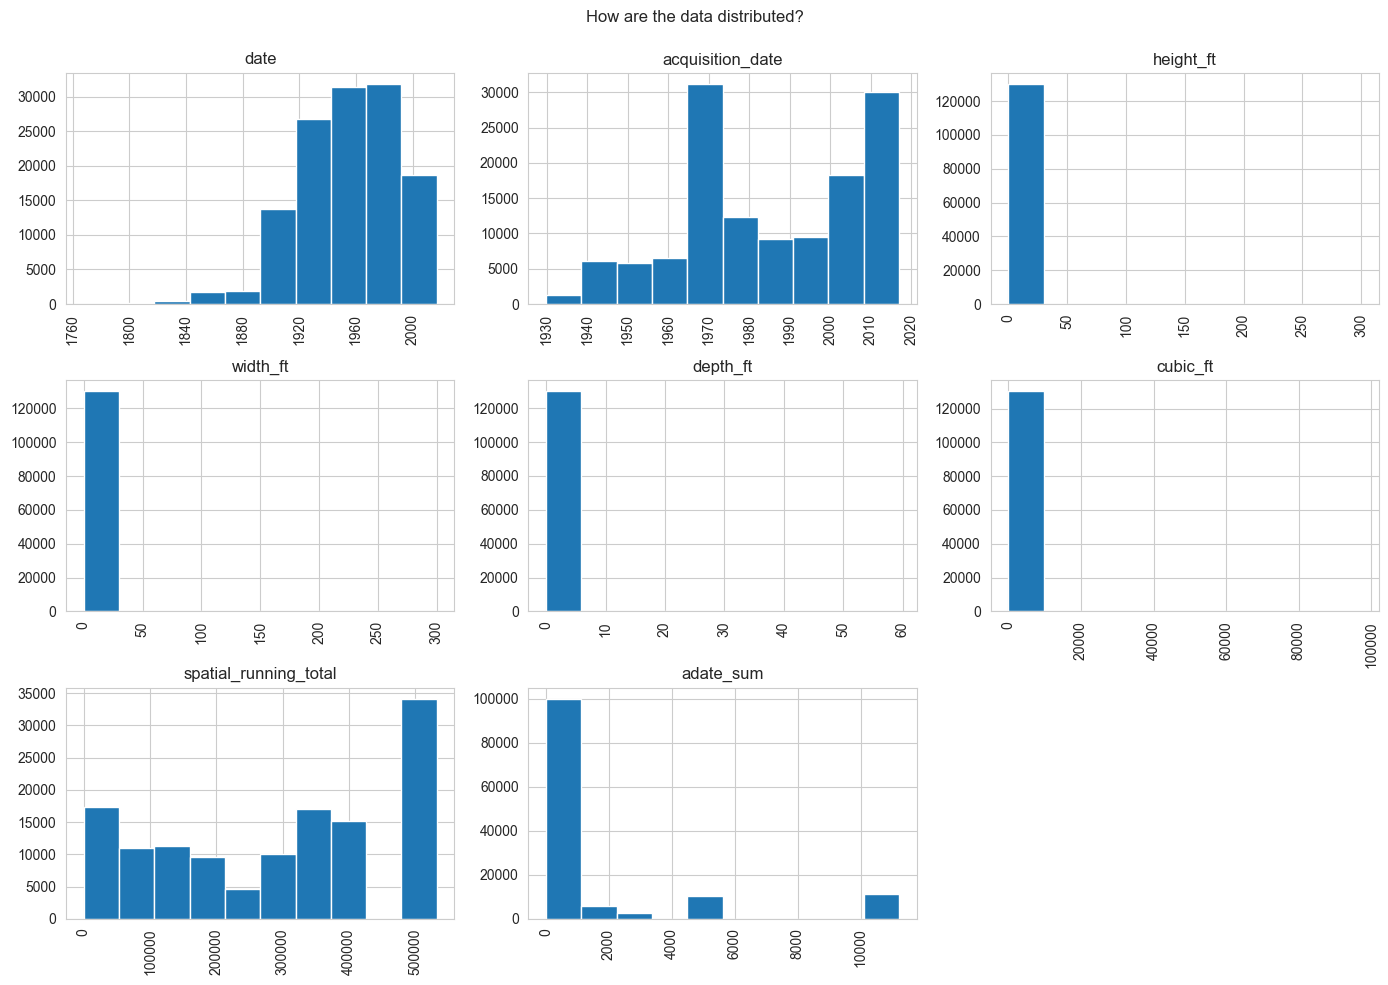

In [212]:
datasets["artworks_data"].hist(
    figsize = (14, 10), 
    xrot = 90,
)
plt.suptitle("How are the data distributed?\n")
plt.tight_layout()
plt.show()
plt.close()

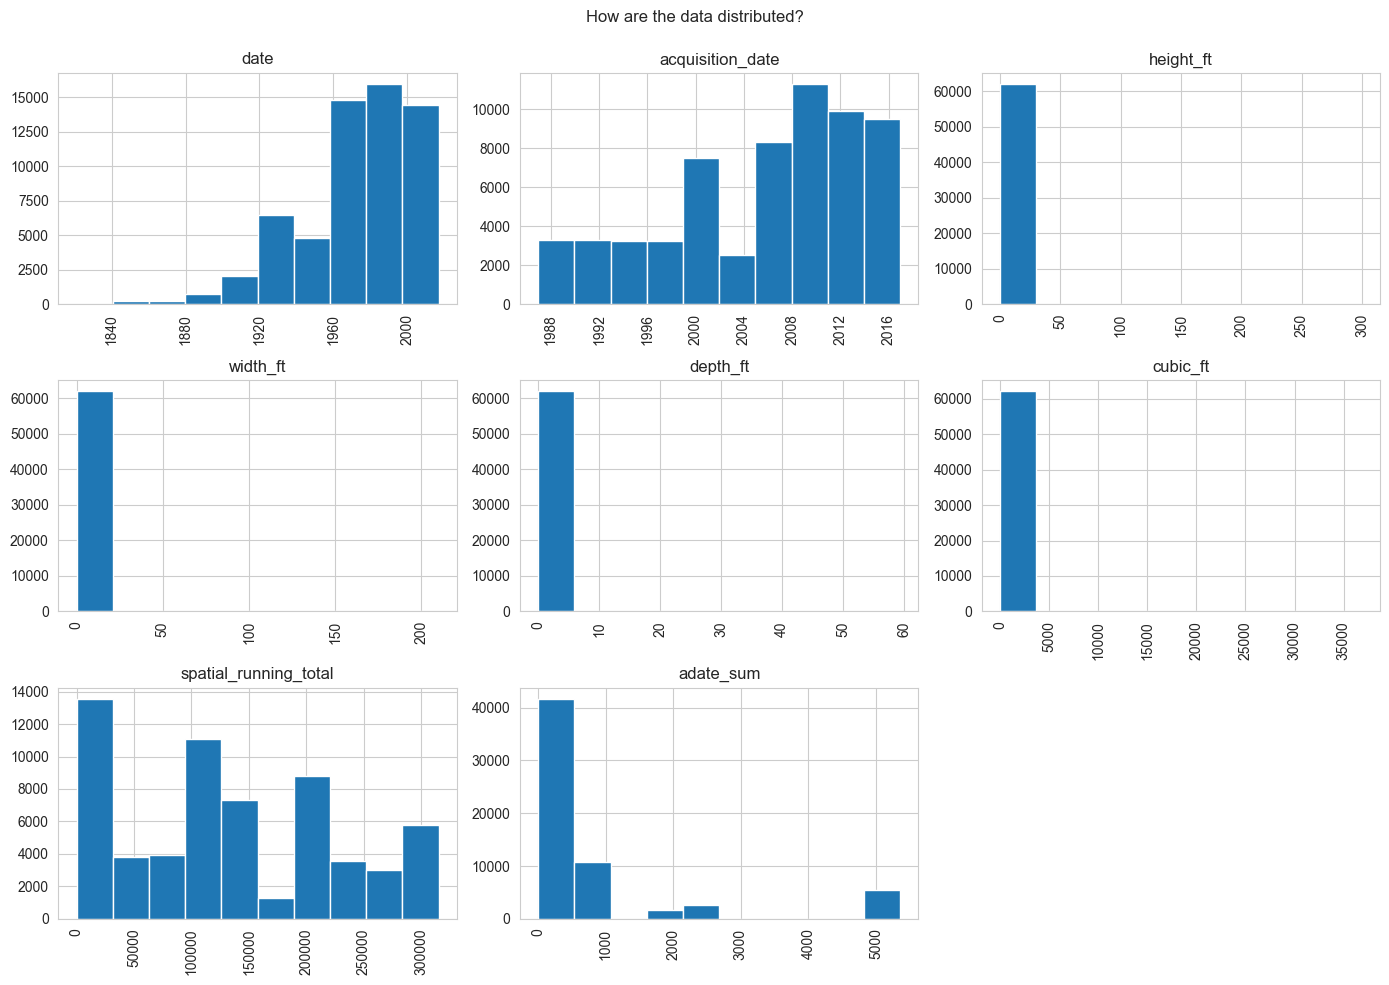

In [213]:
datasets["recent_data"].hist(
    figsize = (14, 10), 
    xrot = 90,
)
plt.suptitle("How are the data distributed?\n")
plt.tight_layout()
plt.show()
plt.close()

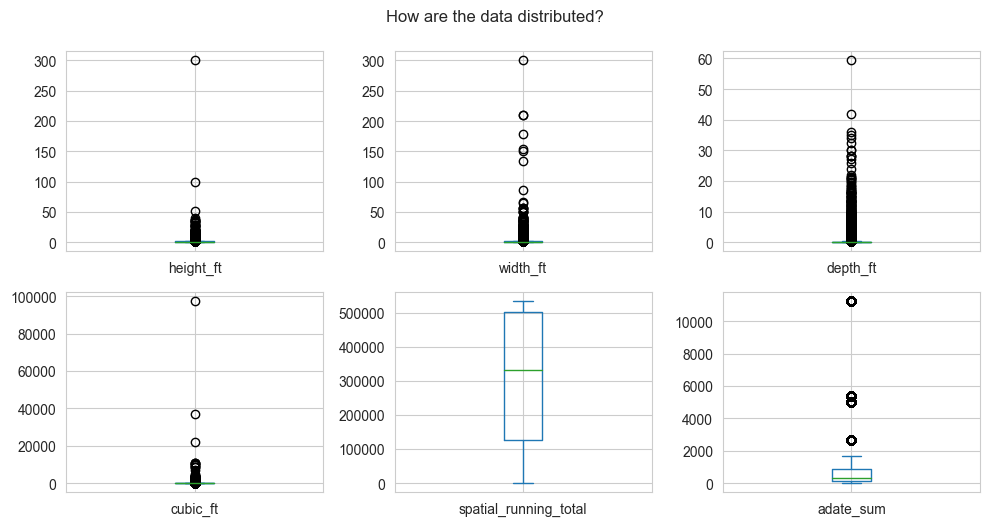

In [214]:
datasets["artworks_data"].plot(
    figsize=(10, 10), 
    kind="box", 
    subplots=True, 
    layout=(4, 3)
);
plt.suptitle("How are the data distributed?\n")
plt.tight_layout()
plt.show()
plt.close()

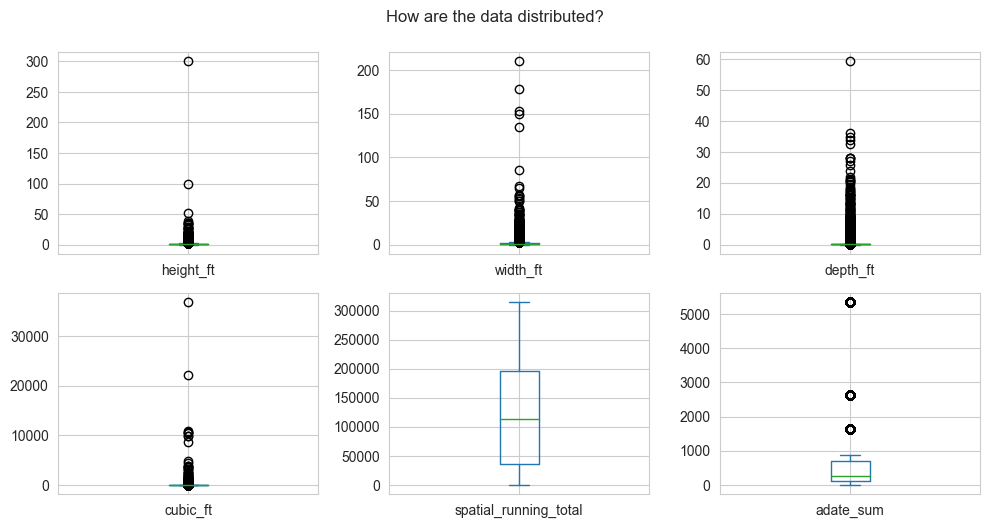

In [215]:
datasets["recent_data"].plot(
    figsize=(10, 10),
    kind="box",
    subplots=True,
    layout=(4, 3)
);
plt.suptitle("How are the data distributed?\n")
plt.tight_layout()
plt.show()
plt.close()

In [216]:
# TODO: Display which Object Numbers are connected to spatial outliers
outliers = detect_IQR_outliers(datasets["artworks_data"].select_dtypes("number"))

Columns which contain outliers outside of the 25th and 75th percentiles:
height_ft                 True
width_ft                  True
depth_ft                  True
cubic_ft                  True
spatial_running_total    False
adate_sum                 True
dtype: bool


In [217]:
ts_columns = pd.Index(["day_of_month", "day_of_year", "week_of_month", "week", "month", "year"])

datasets["artworks_data"].loc[:, numerical_columns] = remove_outliers(datasets["artworks_data"].select_dtypes("number"))
datasets["artworks_tsdata"].loc[:, numerical_columns.difference(ts_columns)] = remove_outliers(datasets["artworks_data"].select_dtypes("number"))

datasets["recent_data"].loc[:, numerical_columns] = remove_outliers(datasets["recent_data"].select_dtypes("number"))
datasets["recent_tsdata"].loc[:, numerical_columns.difference(ts_columns)] = remove_outliers(datasets["recent_data"].select_dtypes("number"))

In [230]:
(datasets["recent_tsdata"].to_csv("NYC-MoMA-Recent-Collections_TS.csv"))

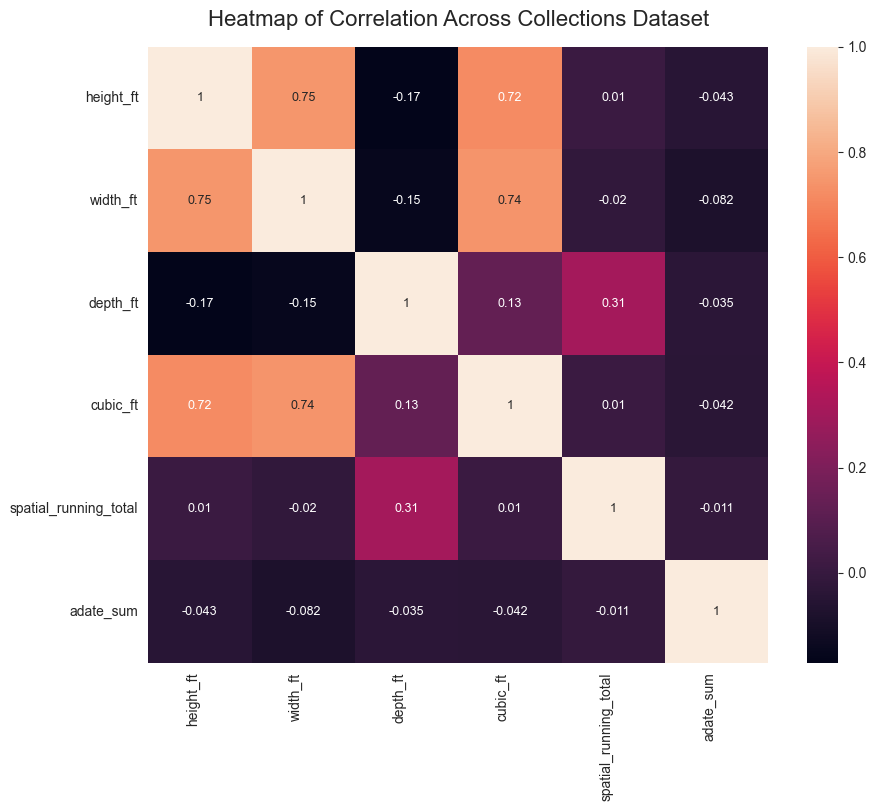

In [218]:
corr_matrix = datasets["artworks_data"].drop(columns=["acc_gaps"]).corr(numeric_only = True)
plt.figure(figsize = (10, 8))
heat_map = sns.heatmap(corr_matrix, annot = True, annot_kws = {"size": 9})
heat_map.set_xticklabels(heat_map.get_xticklabels(), rotation=90, horizontalalignment='right')
heat_map.set_yticklabels(heat_map.get_yticklabels(), rotation=0)
plt.title("Heatmap of Correlation Across Collections Dataset", pad = 15.0, fontsize = 16.0, y = 1.0);
plt.show()
plt.close()

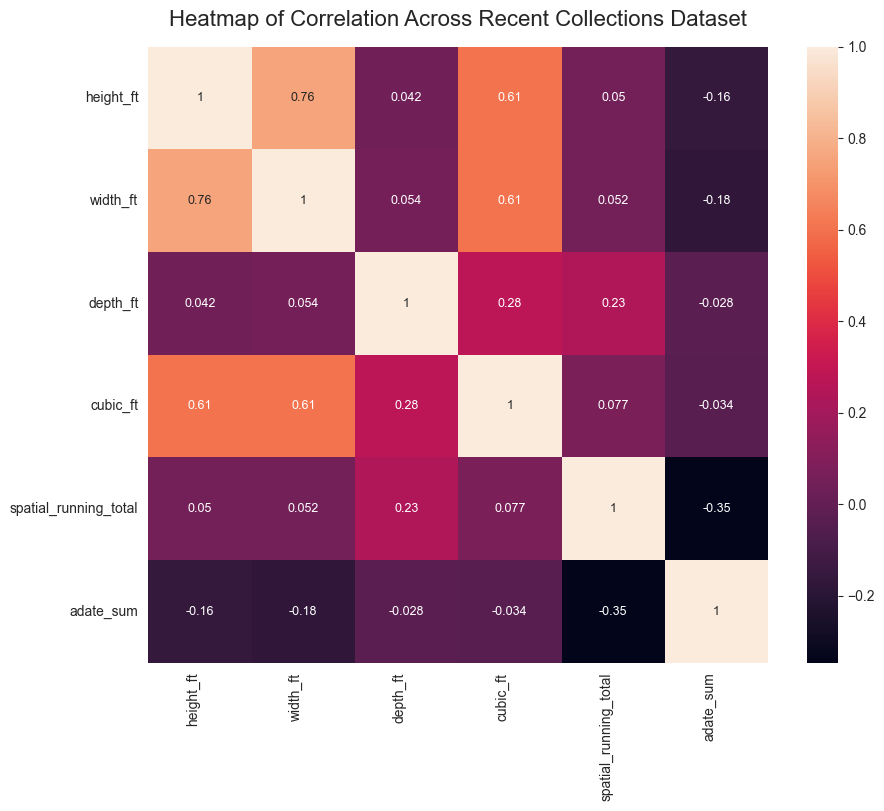

In [219]:
corr_matrix = datasets["recent_data"].drop(columns = ["acc_gaps"]).corr(numeric_only = True)
plt.figure(figsize = (10, 8))
heat_map = sns.heatmap(corr_matrix, annot = True, annot_kws = {"size": 9})
heat_map.set_xticklabels(heat_map.get_xticklabels(), rotation=90, horizontalalignment='right')
heat_map.set_yticklabels(heat_map.get_yticklabels(), rotation=0)
plt.title("Heatmap of Correlation Across Recent Collections Dataset", pad = 15.0, fontsize = 16.0, y = 1.0);
plt.show()
plt.close()

<section id="ts-analysis">
    <h2>Collections Time Series Analysis</h2>
</section>

Explain here why I use the overall dataset and a subset of the overall dataset. Motivated by having the high-level perspective of overall data integrity, and a more nuanced view for interpreting more recent data for estimation purposes.
<br>

<section id="acc-analysis">
    <h3>Accessions Analysis & Decomposition</h3>
</section>

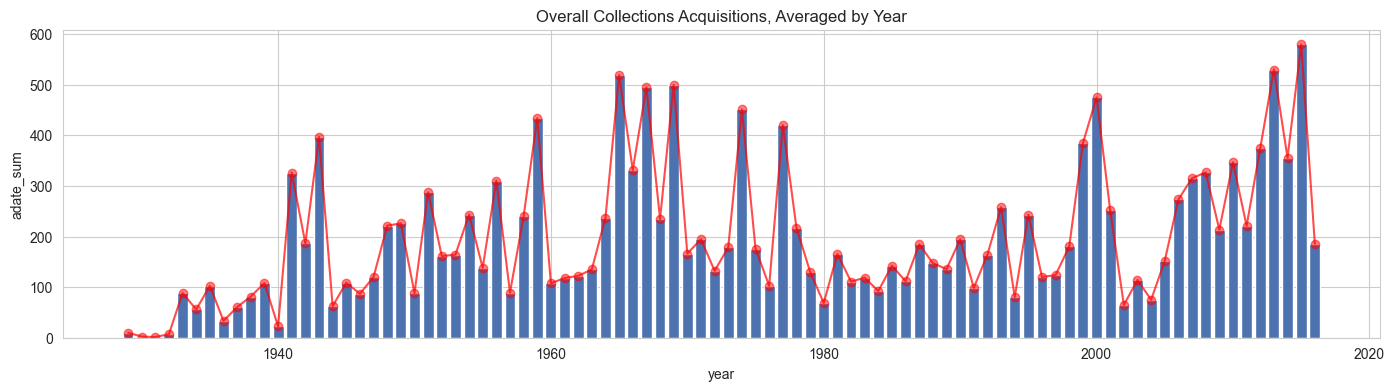

In [220]:
# Accession counts over all-time
yearly_means = datasets["artworks_tsdata"].groupby("year").mean(numeric_only = True).reset_index()
plt.figure(figsize = (17, 4))
plt.bar(x = "year", height = "adate_sum", color = sns.color_palette("deep")[0], data = yearly_means)
sns.lineplot(yearly_means, x = "year", y = "adate_sum", color = "red", alpha = 0.7)
plt.scatter(x = "year", y = "adate_sum", color = "red", marker = "o", data = yearly_means, alpha = 0.5)
plt.title("Overall Collections Acquisitions, Averaged by Year");
plt.show()
plt.close()

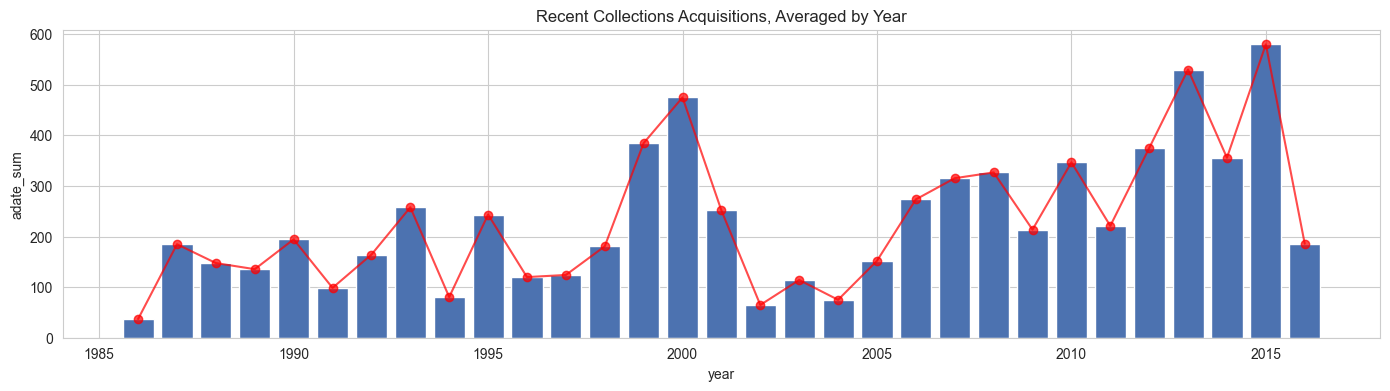

In [221]:
yearly_means = datasets["recent_tsdata"].groupby("year").mean(numeric_only = True).reset_index()
plt.figure(figsize = (17, 4))
plt.bar(x = "year", height = "adate_sum", color = sns.color_palette("deep")[0], data = yearly_means)
sns.lineplot(yearly_means, x = "year", y = "adate_sum", color = "red", alpha = 0.7)
plt.scatter(x = "year", y = "adate_sum", color = "red", marker = "o", data = yearly_means, alpha = 0.7)
plt.title("Recent Collections Acquisitions, Averaged by Year");
plt.show()
plt.close()

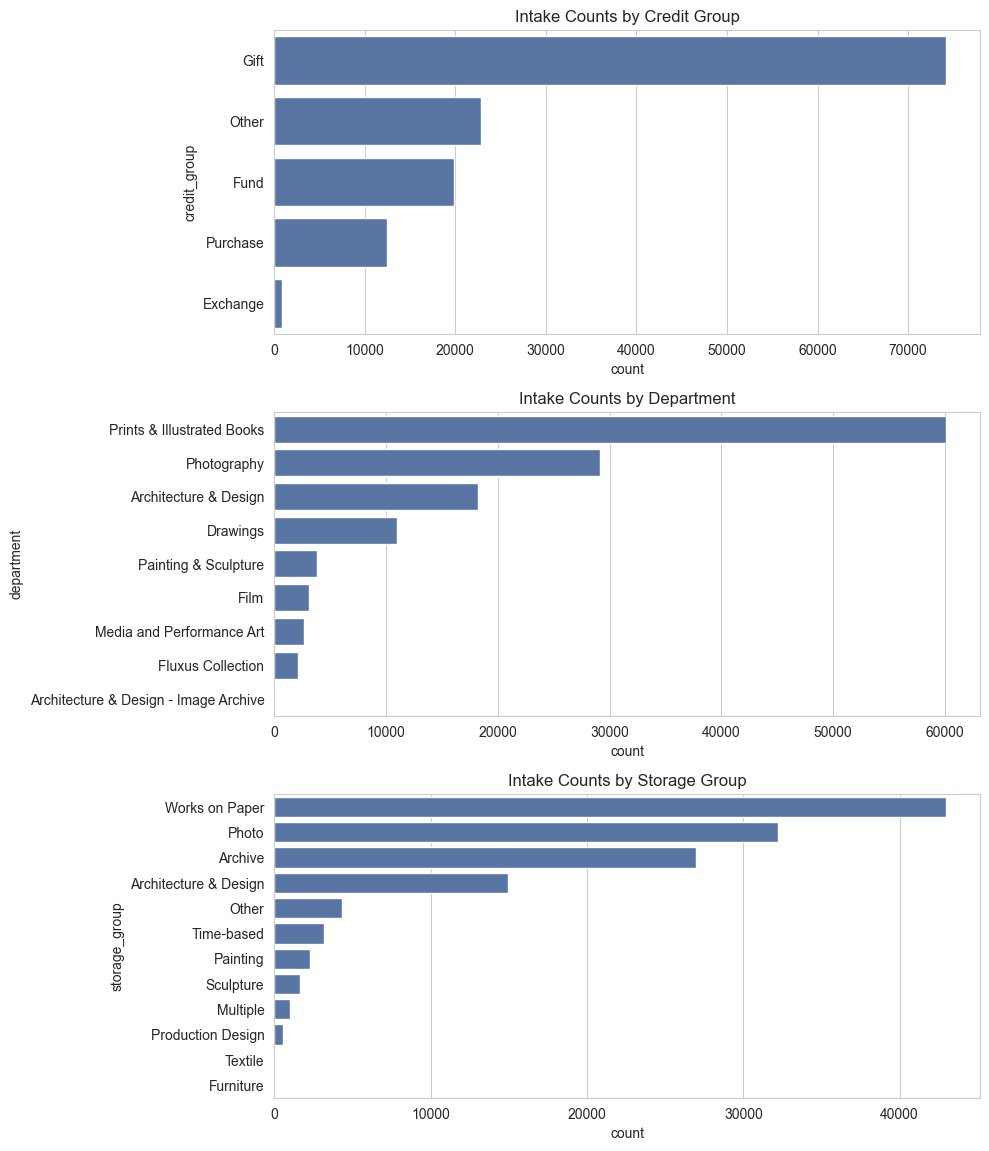

In [222]:
# Overall accession counts by credit, department, and storage group
plt.figure(figsize = (10, 15))
for idx, category in enumerate(hue_categories, 1):
    # Acquistion date counts
    plt.subplot(4, 1, idx)
    sns.countplot(
        y = category,
        data = datasets["artworks_data"],
        # sorts plots by descending order for visual clarity
        order = datasets["artworks_data"][category].value_counts().index,
        color = sns.color_palette("deep")[0]
    )
    plt.title(f"Intake Counts by {category.replace('_', ' ').title()}")
plt.tight_layout()
plt.show()

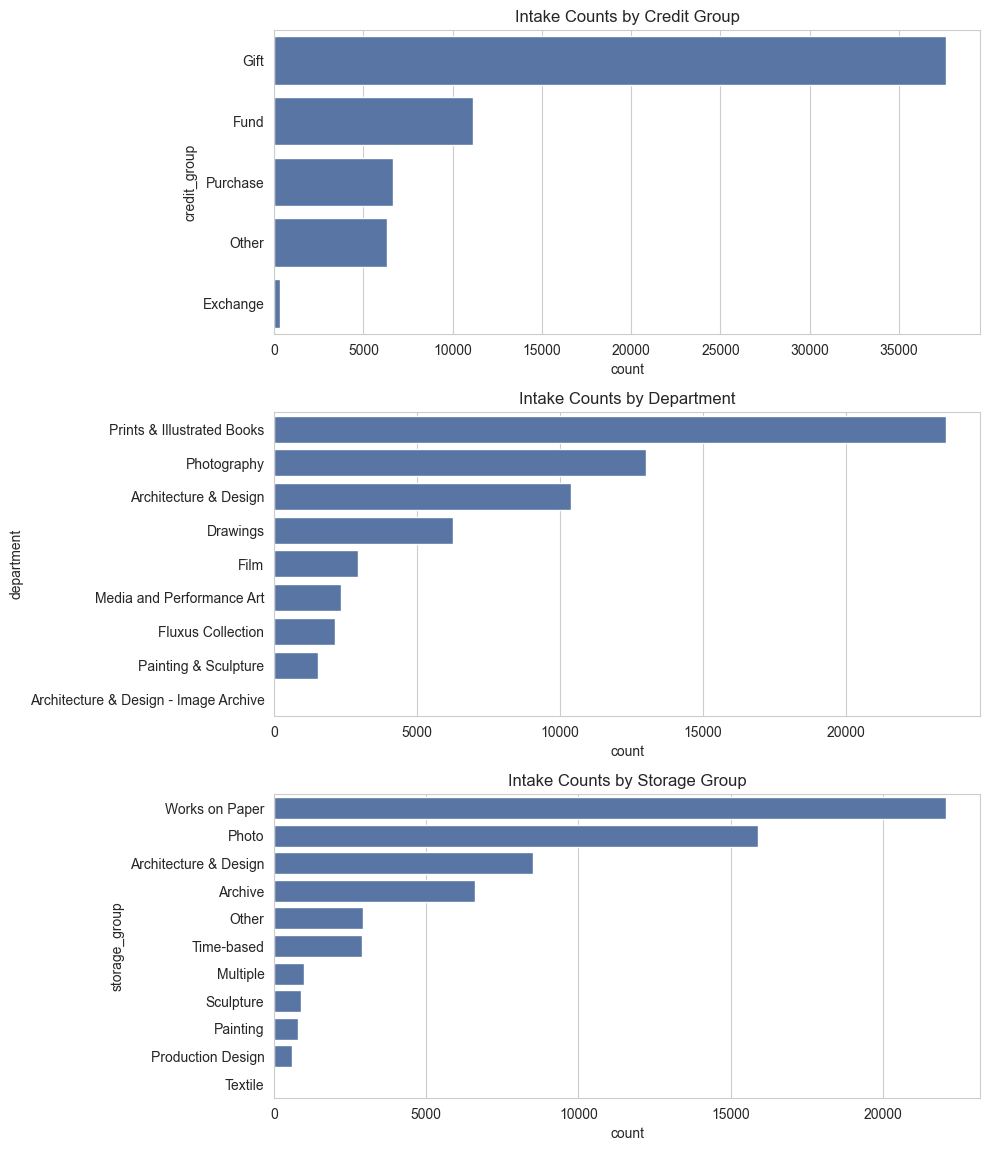

In [223]:
plt.figure(figsize = (10, 15))
for idx, category in enumerate(hue_categories, 1):
    # Acquistion date counts
    plt.subplot(4, 1, idx)
    sns.countplot(
        y = category,
        data = datasets["recent_tsdata"],
        # sorts plots by descending order for visual clarity
        order = datasets["recent_data"][category].value_counts().index,
        color = sns.color_palette("deep")[0]
    )
    plt.title(f"Intake Counts by {category.replace('_', ' ').title()}")
plt.tight_layout()
plt.show()

<section id="gap-analysis">
    <h2>Time Series Analysis of Acquisition Counts</h2>
</section>

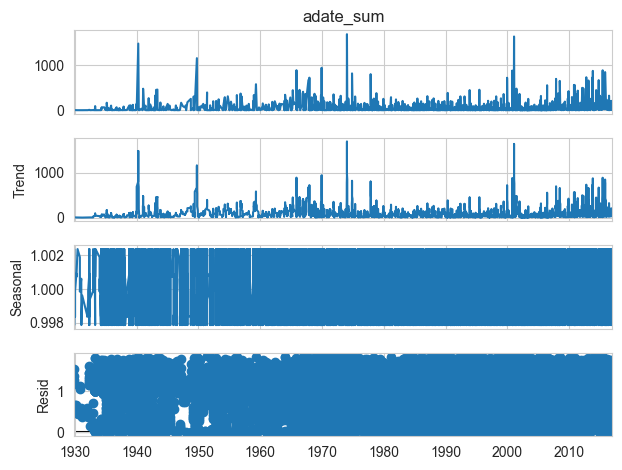

In [224]:
ts_data = (datasets["artworks_data"]
           .set_index("acquisition_date")
           .sort_index()
           ["adate_sum"]
           .dropna())
decomposition = sm.tsa.seasonal_decompose(ts_data, model="multiplicative", period = 12)
decomposition.plot();

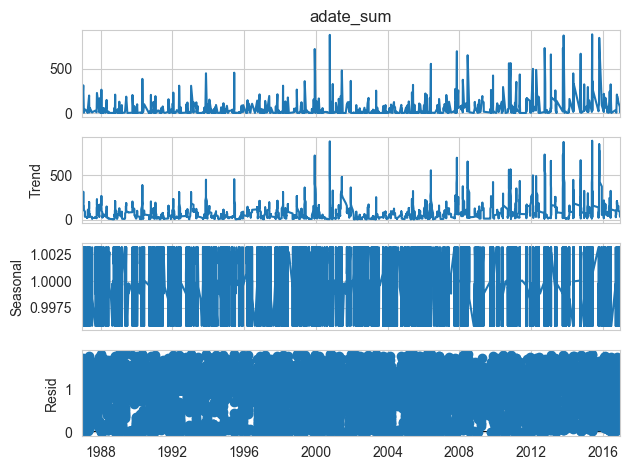

In [225]:
ts_data = (datasets["recent_data"]
           .set_index("acquisition_date")
           .sort_index()
           ["adate_sum"]
           .dropna())
decomposition = sm.tsa.seasonal_decompose(ts_data, model="multiplicative", period = 12)
decomposition.plot();

In [226]:
n = 25
print("Overall Durations of Gaps in between Acquisitions")
# print("Longest gap:", datasets["artworks_data"]["acc_gaps"].max())
# print("Shortest gap:", datasets["artworks_data"]["acc_gaps"].min())
# print("Average gap:", datasets["artworks_data"]["acc_gaps"].mean())
print(f"Top {n} Most Common gap durations:\n", datasets["artworks_data"]["acc_gaps"].value_counts().head(n))

Overall Durations of Gaps in between Acquisitions
Top 25 Most Common gap durations:
 acc_gaps
0 days      128387
-1 days        318
-2 days        137
-3 days        112
-5 days         88
-4 days         84
-6 days         79
-7 days         78
-8 days         61
-9 days         54
-10 days        43
-28 days        40
-11 days        40
-21 days        39
-13 days        39
-15 days        38
-12 days        38
-14 days        36
-18 days        33
-19 days        33
-20 days        32
-22 days        28
-16 days        25
-26 days        24
-17 days        23
Name: count, dtype: int64


In [227]:
n = 25
print(f"Latest {n} Years of Durations of Gaps in between Acquisitions")
# print("Longest gap:", datasets["recent_data"]["acc_gaps"].max())
# print("Shortest gap:", datasets["recent_data"]["acc_gaps"].min())
# print("Average gap:", datasets["recent_data"]["acc_gaps"].mean())
print(f"Top {n} Most Common gap durations:\n", datasets["recent_data"]["acc_gaps"].value_counts().head(n))

Latest 25 Years of Durations of Gaps in between Acquisitions
Top 25 Most Common gap durations:
 acc_gaps
0 days      61151
-1 days       225
-2 days        84
-3 days        70
-5 days        51
-4 days        46
-6 days        45
-7 days        43
-8 days        29
-9 days        28
-11 days       24
-12 days       23
-10 days       23
-15 days       22
-18 days       21
-13 days       21
-20 days       20
-19 days       16
-14 days       14
-21 days       14
-16 days       12
-27 days       12
-26 days        9
-22 days        9
-23 days        9
Name: count, dtype: int64


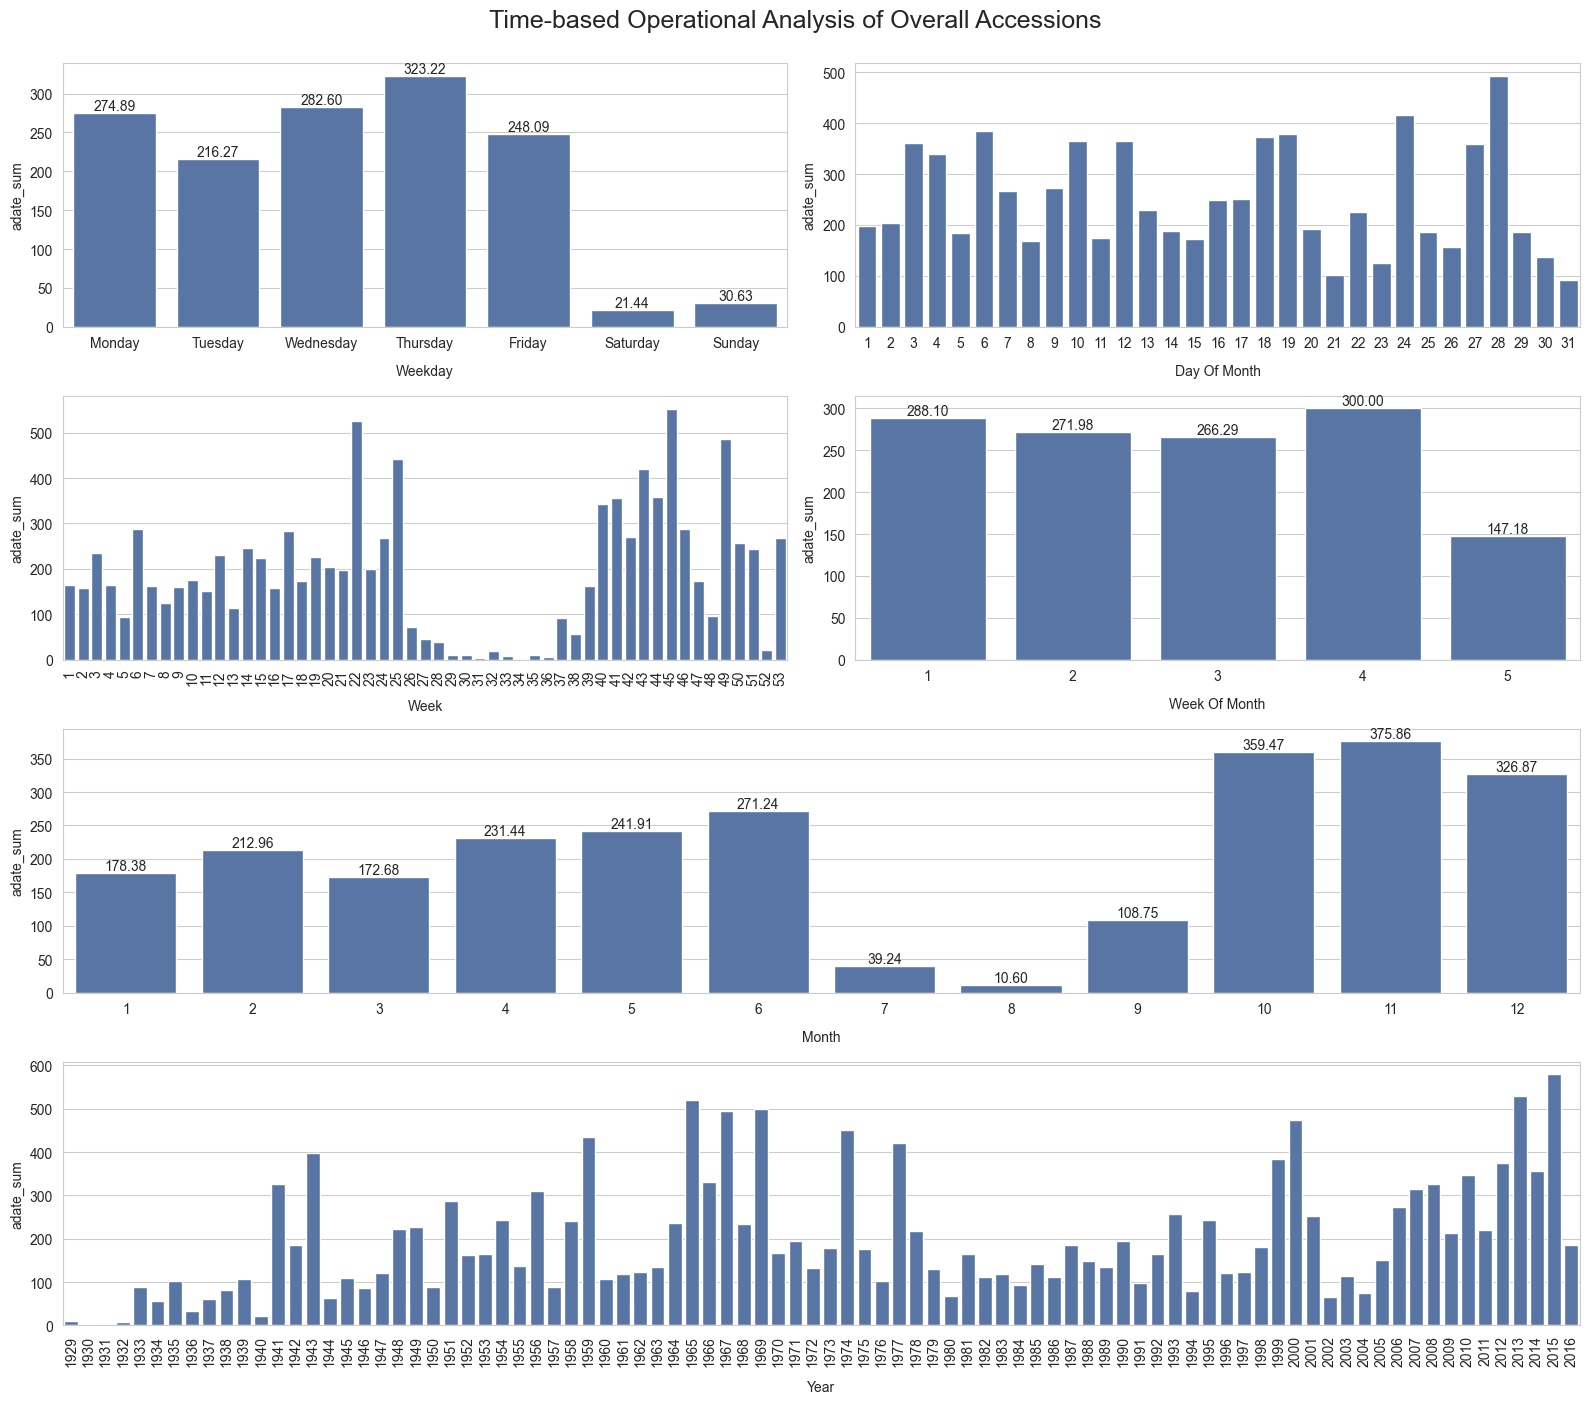

In [228]:
time_columns = ["weekday", "day_of_month", "week", "week_of_month", "month", "year"]
fig, axs = plt.subplots(4, 2, figsize=(16, 14))
plt.suptitle(f"Time-based Operational Analysis of Overall Accessions", fontsize = 18, y = 1.0)

for i, column in enumerate(time_columns[:-2]):
    ax = axs[i // 2, i % 2]  # Calculate row and column index
    sns.barplot(data=datasets["artworks_tsdata"], x = column, y = "adate_sum", ax = ax, color = sns.color_palette("deep")[0], errorbar=("ci", False))
    ax.set_xlabel(column.title().replace("_", " "), labelpad = 10)
    if len(datasets["artworks_tsdata"][column].unique()) <= 8:
        for p in ax.patches:
            ax.annotate(f'{p.get_height():.2f}', 
                            (p.get_x() + p.get_width() / 2., p.get_height()),
                            ha='center', va='bottom')
    plt.tight_layout()
axs[2, 1].remove()
axs[2, 0].remove()
axs[3, 1].remove()
axs[3, 0].remove()

combined_ax = fig.add_subplot(4, 1, 3)  # combined plot row
sns.barplot(data = datasets["artworks_tsdata"], x = "month", y = "adate_sum", ax = combined_ax, color = sns.color_palette("deep")[0], errorbar=("ci", False))
combined_ax.set_xlabel("month".title(), labelpad = 10)
for p in combined_ax.patches:
    combined_ax.annotate(f'{p.get_height():.2f}',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom')

combined_ax2 = fig.add_subplot(4, 1, 4)  # combined plot row
sns.barplot(data = datasets["artworks_tsdata"], x = "year", y = "adate_sum", ax = combined_ax2, color = sns.color_palette("deep")[0], errorbar=("ci", False))
combined_ax2.set_xlabel("year".title(), labelpad = 10)

# Rotate x-axis labels for "week" and "year"
axs[1, 0].set_xticklabels(axs[1, 0].get_xticklabels(), rotation = 90)  # For "week"
combined_ax2.set_xticklabels(combined_ax2.get_xticklabels(), rotation = 90)  # For "year"
plt.tight_layout()
plt.show()
plt.close(fig)

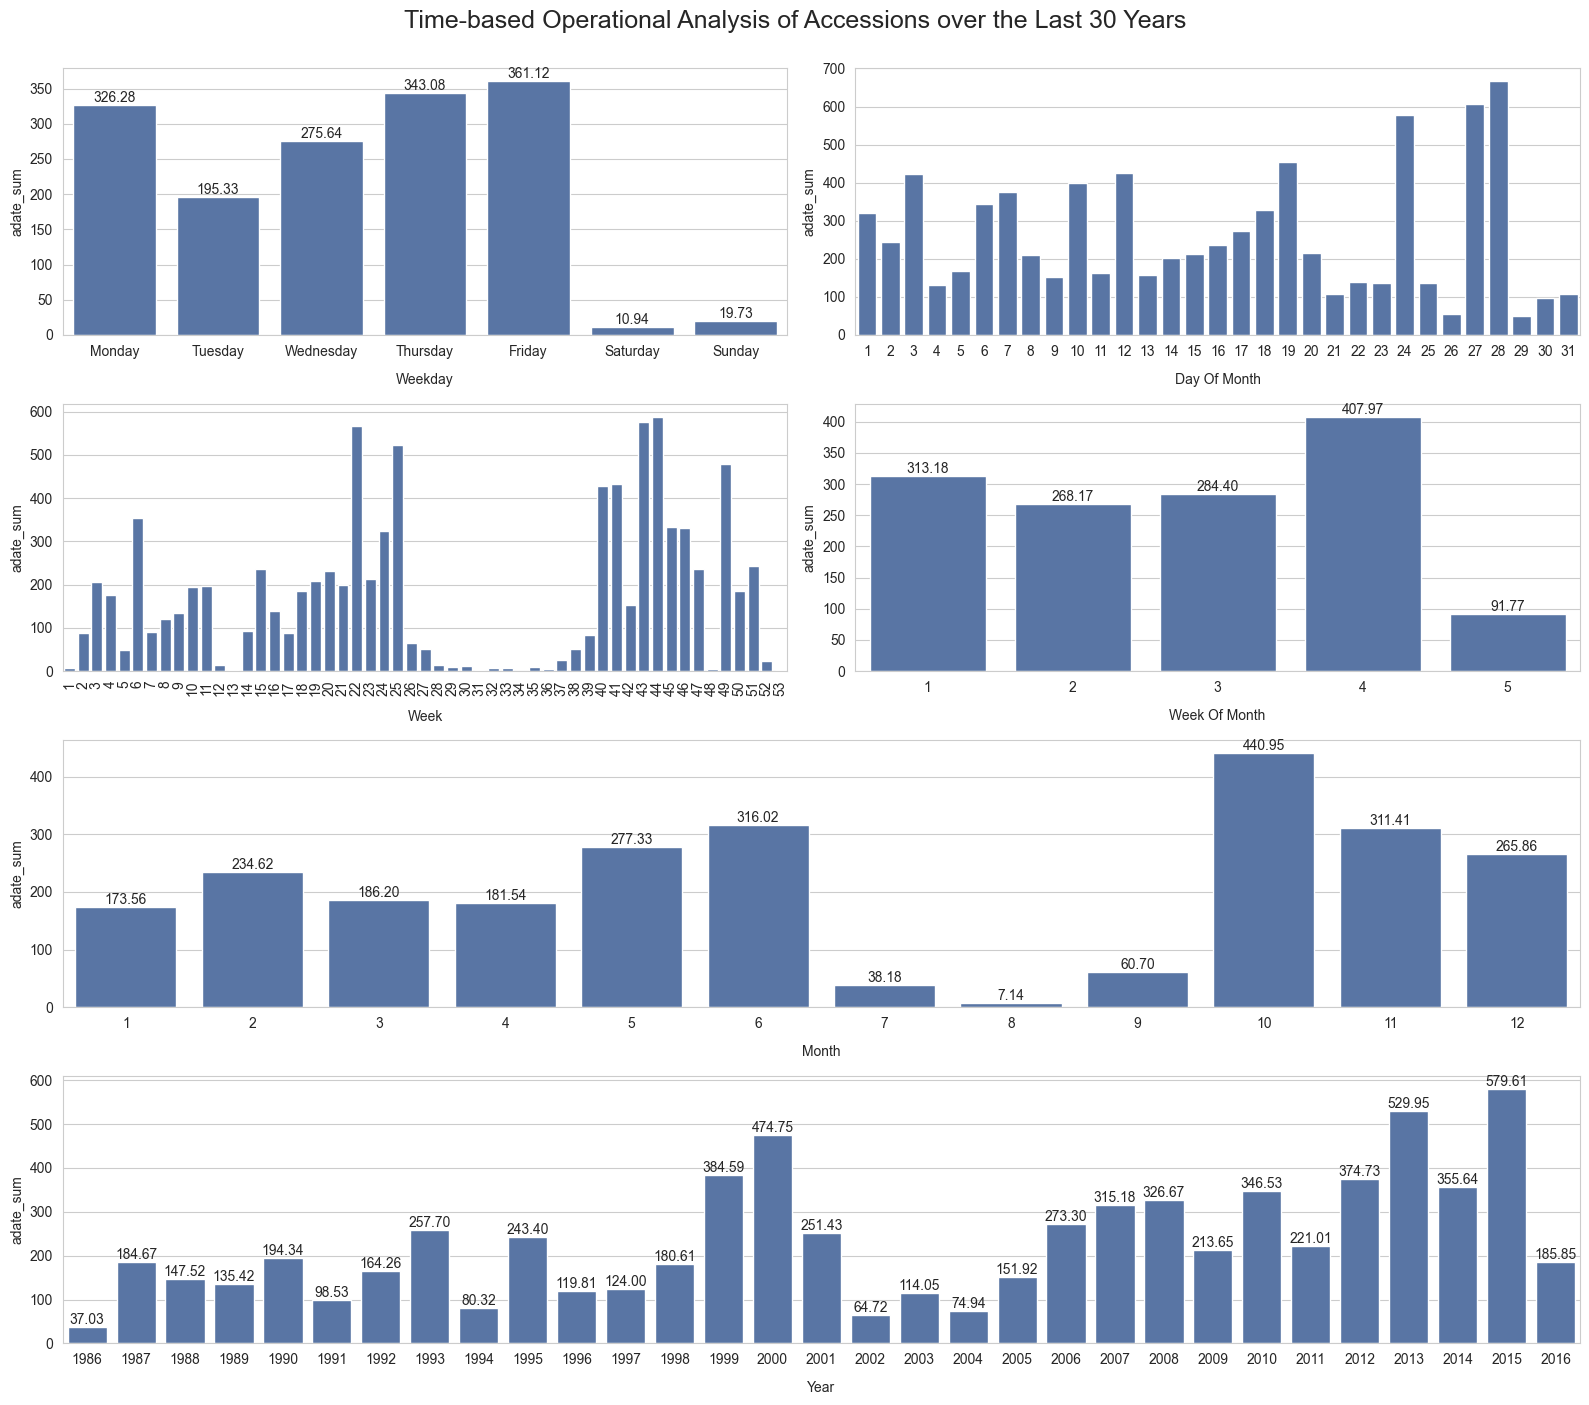

In [229]:
time_columns = ["weekday", "day_of_month", "week", "week_of_month", "month", "year"]
fig, axs = plt.subplots(4, 2, figsize=(16, 14))
plt.suptitle(f"Time-based Operational Analysis of Accessions over the Last 30 Years", fontsize = 18, y = 1.0)

for i, column in enumerate(time_columns[:-2]):
    ax = axs[i // 2, i % 2]  # Calculate row and column index
    sns.barplot(data=datasets["recent_tsdata"], x = column, y = "adate_sum", ax = ax, color = sns.color_palette("deep")[0], errorbar=("ci", False))
    ax.set_xlabel(column.title().replace("_", " "), labelpad = 10)
    if len(datasets["recent_tsdata"][column].unique()) <= 8:
        for p in ax.patches:
            ax.annotate(f'{p.get_height():.2f}', 
                            (p.get_x() + p.get_width() / 2., p.get_height()),
                            ha='center', va='bottom')
    plt.tight_layout()
axs[2, 1].remove()
axs[2, 0].remove()
axs[3, 1].remove()
axs[3, 0].remove()

combined_ax = fig.add_subplot(4, 1, 3)  # combined plot row
sns.barplot(data = datasets["recent_tsdata"], x = "month", y = "adate_sum", ax = combined_ax, color = sns.color_palette("deep")[0], errorbar=("ci", False))
combined_ax.set_xlabel("month".title(), labelpad = 10)
for p in combined_ax.patches:
    combined_ax.annotate(f'{p.get_height():.2f}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom')

combined_ax2 = fig.add_subplot(4, 1, 4)  # combined plot row
sns.barplot(data = datasets["recent_tsdata"], x = "year", y = "adate_sum", ax = combined_ax2, color = sns.color_palette("deep")[0], errorbar=("ci", False))
combined_ax2.set_xlabel("year".title(), labelpad = 10)
for p in combined_ax2.patches:
    combined_ax2.annotate(f'{p.get_height():.2f}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom')

# Rotate x-axis labels for "week" and "year"
axs[1, 0].set_xticklabels(axs[1, 0].get_xticklabels(), rotation = 90)  # For "week"
# combined_ax2.set_xticklabels(combined_ax2.get_xticklabels(), rotation = 90)  # For "year"
plt.tight_layout()
plt.show()
plt.close(fig)

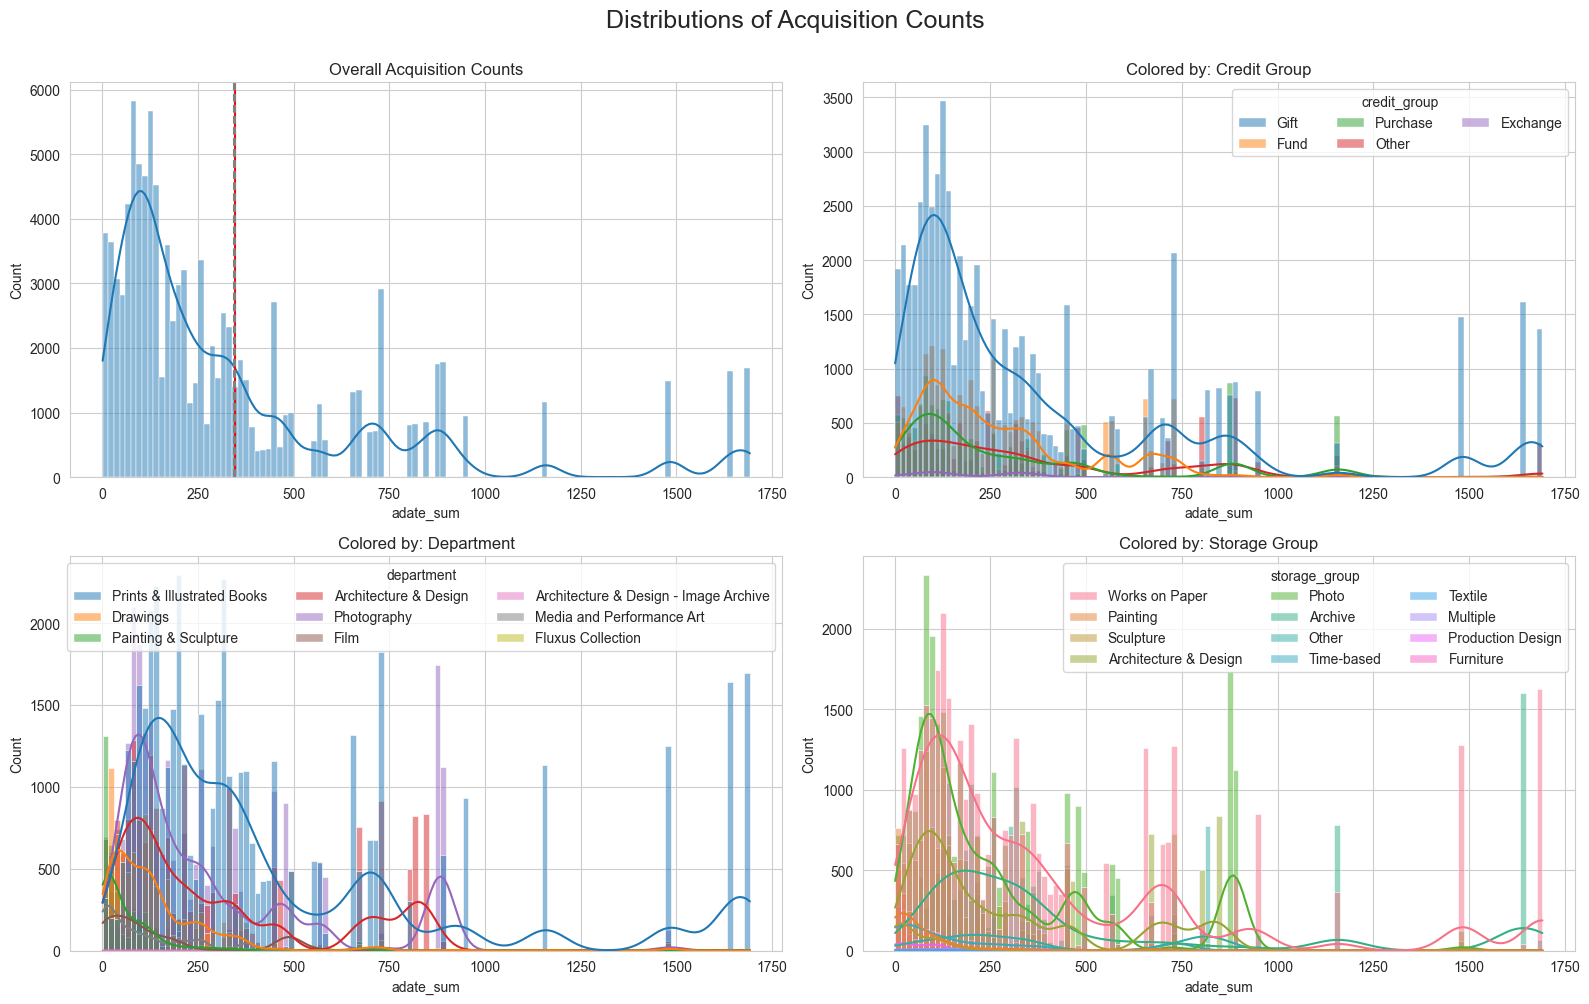

In [168]:
fig, axs = plt.subplots(2, 2, figsize=(16, 10))
plt.suptitle("Distributions of Acquisition Counts", fontsize = 18, y = 1.0)
ci = calculate_confidence_intervals_95(datasets["artworks_data"], "adate_sum")
sns.histplot(data=datasets["artworks_data"], x = "adate_sum", kde = True, ax = axs[0, 0])
axs[0, 0].axvline(np.mean(datasets["artworks_data"]["adate_sum"]), color = "red")
axs[0, 0].axvline(ci[0], color="gray", linestyle = "--")
axs[0, 0].axvline(ci[1], color="gray", linestyle = "--")
axs[0, 0].set_title("Overall Acquisition Counts")

for i, column in enumerate(hue_categories, 1):
    column_title = column.title().replace("_", " ")
    ax = axs[i // 2, i % 2]  # Calculate row and column index
    sns.histplot(data=datasets["artworks_data"], x = "adate_sum", hue = column, kde = True, ax = ax)
    ax.set_title(f"Colored by: {column_title}")
    sns.move_legend(ax, loc = "upper right", ncol=3)

    plt.tight_layout()
plt.show()
plt.close()

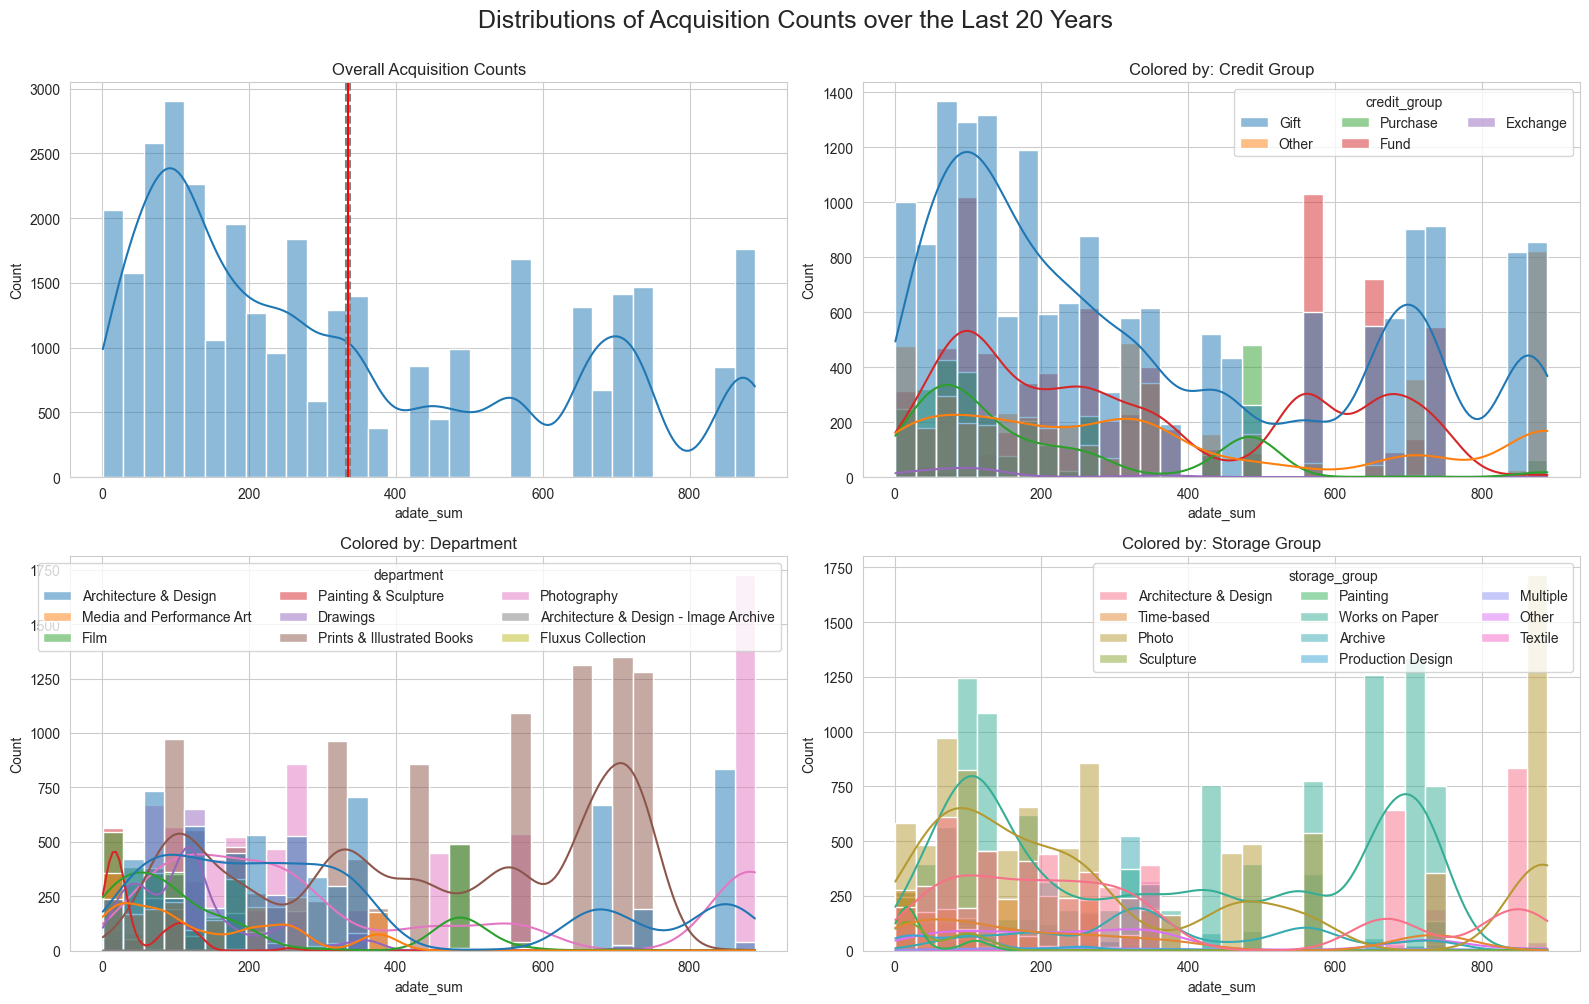

In [169]:
fig, axs = plt.subplots(2, 2, figsize=(16, 10))
plt.suptitle("Distributions of Acquisition Counts over the Last 20 Years", fontsize = 18, y = 1.0)
ci = calculate_confidence_intervals_95(datasets["recent_data"], "adate_sum")
sns.histplot(data=datasets["recent_data"], x = "adate_sum", kde = True, ax = axs[0, 0])
axs[0, 0].axvline(np.mean(datasets["recent_data"]["adate_sum"]), color = "red")
axs[0, 0].axvline(ci[0], color="gray", linestyle = "--")
axs[0, 0].axvline(ci[1], color="gray", linestyle = "--")
axs[0, 0].set_title("Overall Acquisition Counts")

for i, column in enumerate(hue_categories, 1):
    column_title = column.title().replace("_", " ")
    ax = axs[i // 2, i % 2]  # Calculate row and column index
    sns.histplot(data=datasets["recent_data"], x = "adate_sum", hue = column, kde = True, ax = ax)
    ax.set_title(f"Colored by: {column_title}")
    sns.move_legend(ax, loc = "upper right", ncol=3)

    plt.tight_layout()
plt.show()
plt.close()

Text(0.5, 1.0, 'Date of Works plotted against Acquisition Dates')

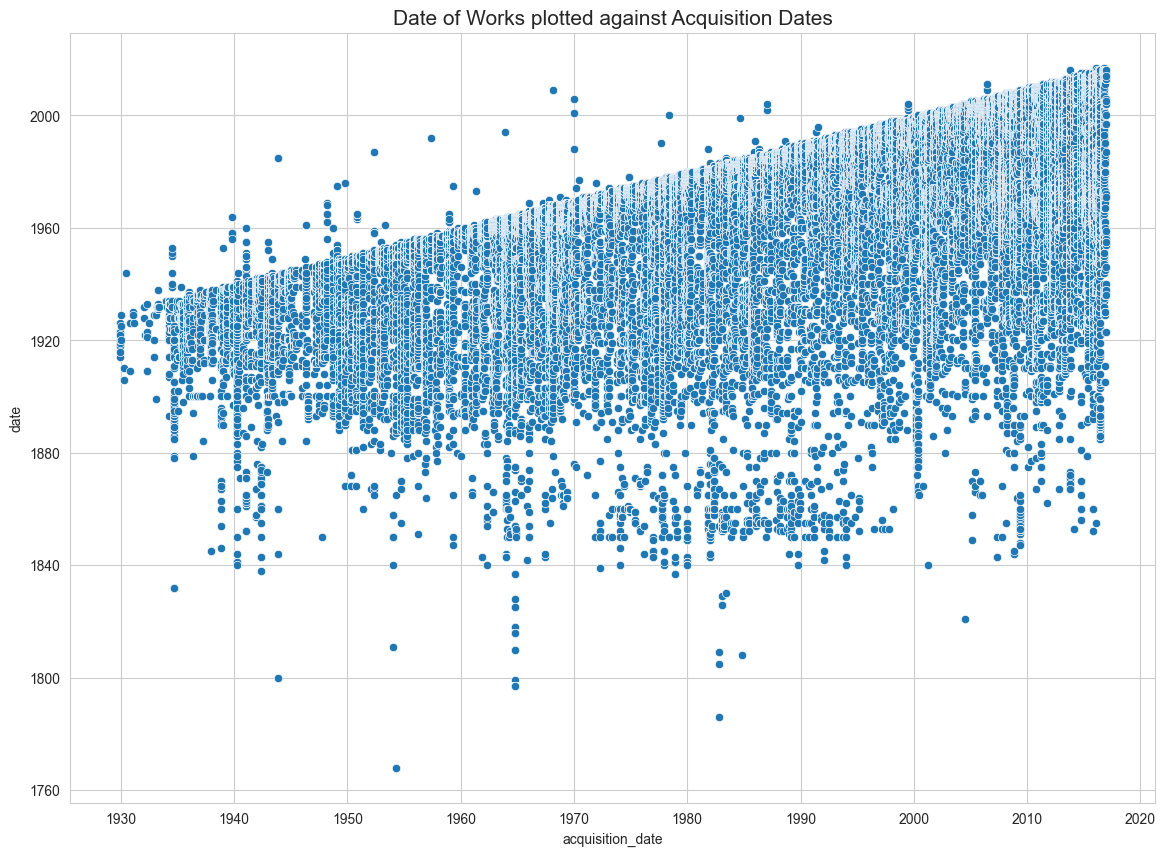

In [170]:
# Table: How contemporary are the intake practices of the NYC MoMA?
plt.figure(figsize = (14, 10))
sns.scatterplot(datasets["artworks_tsdata"], x = "acquisition_date", y = "date")
plt.title("Date of Works plotted against Acquisition Dates", fontsize = 15, y = 1.0)

<section id="spatial-stats">
    <h2>Spatial Descriptive Statistics - Histograms, Boxplots, and Totals by [Overall, Credit, Dept, Storage_Group]</h2>
</section>

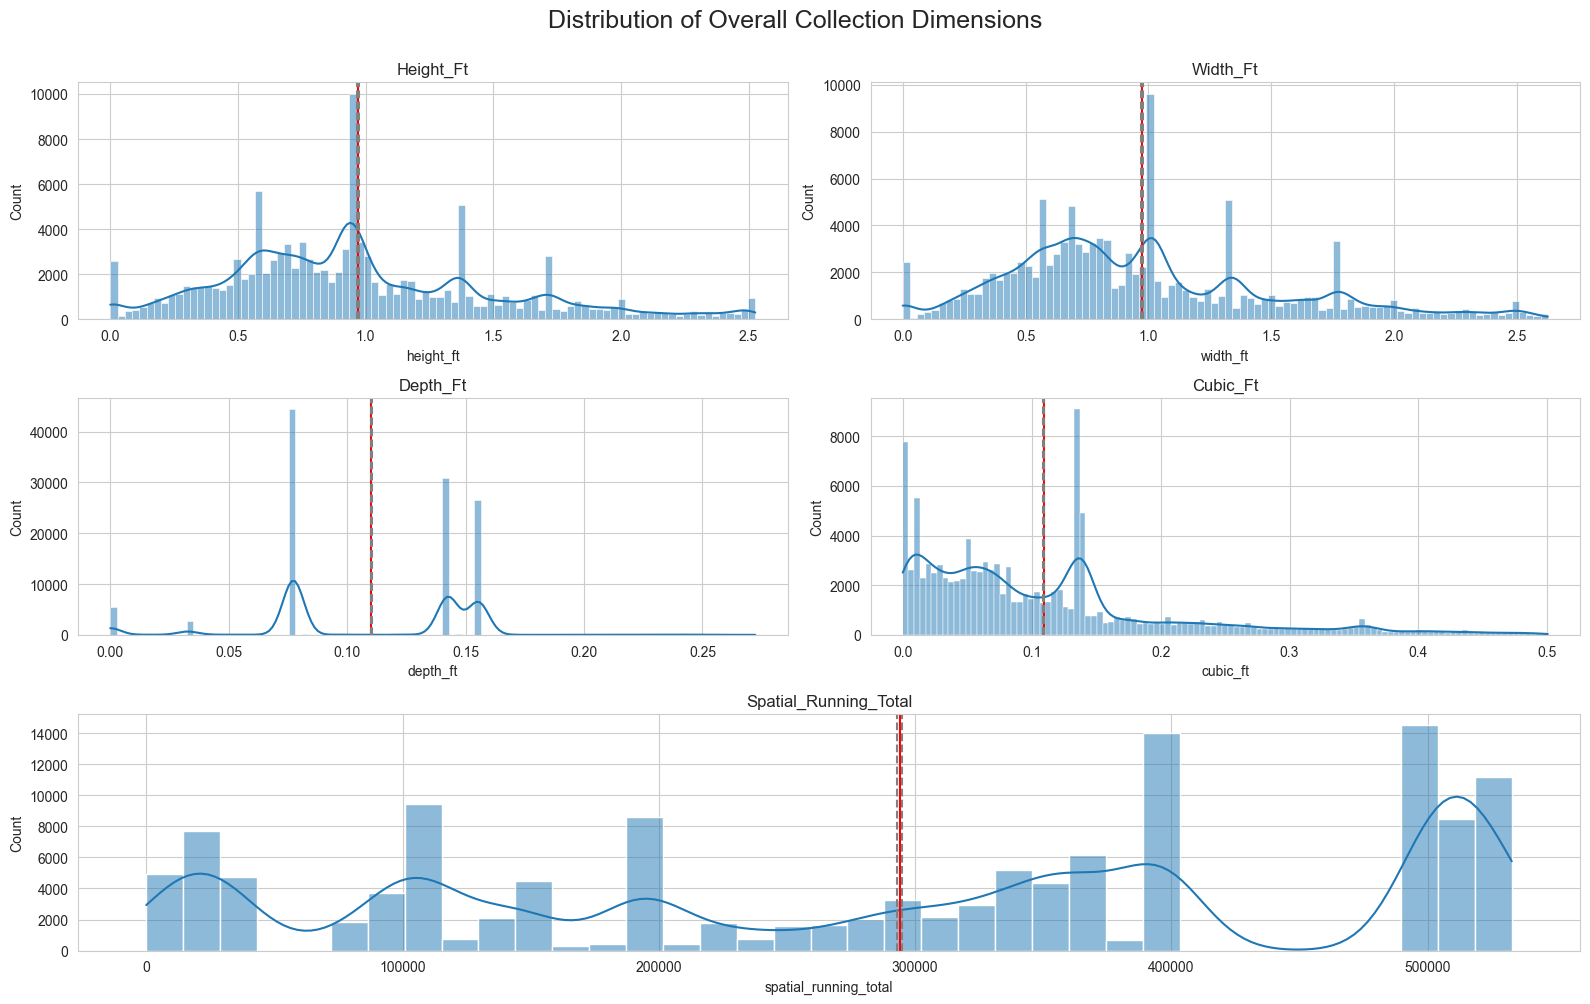

In [171]:
fig, axs = plt.subplots(3, 2, figsize=(16, 10))
plt.suptitle(f"Distribution of Overall Collection Dimensions", fontsize = 18, y = 1.0)

for i, column in enumerate(spatial_columns[:-1]):
    ax = axs[i // 2, i % 2]  # Calculate row and column index
    ci = calculate_confidence_intervals_95(datasets["artworks_data"], column)
    sns.histplot(data=datasets["artworks_data"], x = column, ax = ax, kde = True)
    ax.axvline(np.mean(datasets["artworks_data"][column]), color = "red")
    ax.axvline(ci[0], color="gray", linestyle = "--")
    ax.axvline(ci[1], color="gray", linestyle = "--")
    ax.set_title(column.title())
axs[2, 1].remove()
axs[2, 0].remove()

combined_ax = fig.add_subplot(3, 1, 3)  # combined plot row
sns.histplot(data = datasets["artworks_data"], x = "spatial_running_total", ax = combined_ax, kde = True)
ci = calculate_confidence_intervals_95(datasets["artworks_data"], "spatial_running_total")
combined_ax.axvline(np.mean(datasets["artworks_data"]["spatial_running_total"]), color="red")
combined_ax.axvline(ci[0], color="gray", linestyle = "--")
combined_ax.axvline(ci[1], color="gray", linestyle = "--")
combined_ax.set_title("spatial_running_total".title())
plt.tight_layout()
plt.show()
plt.close(fig)

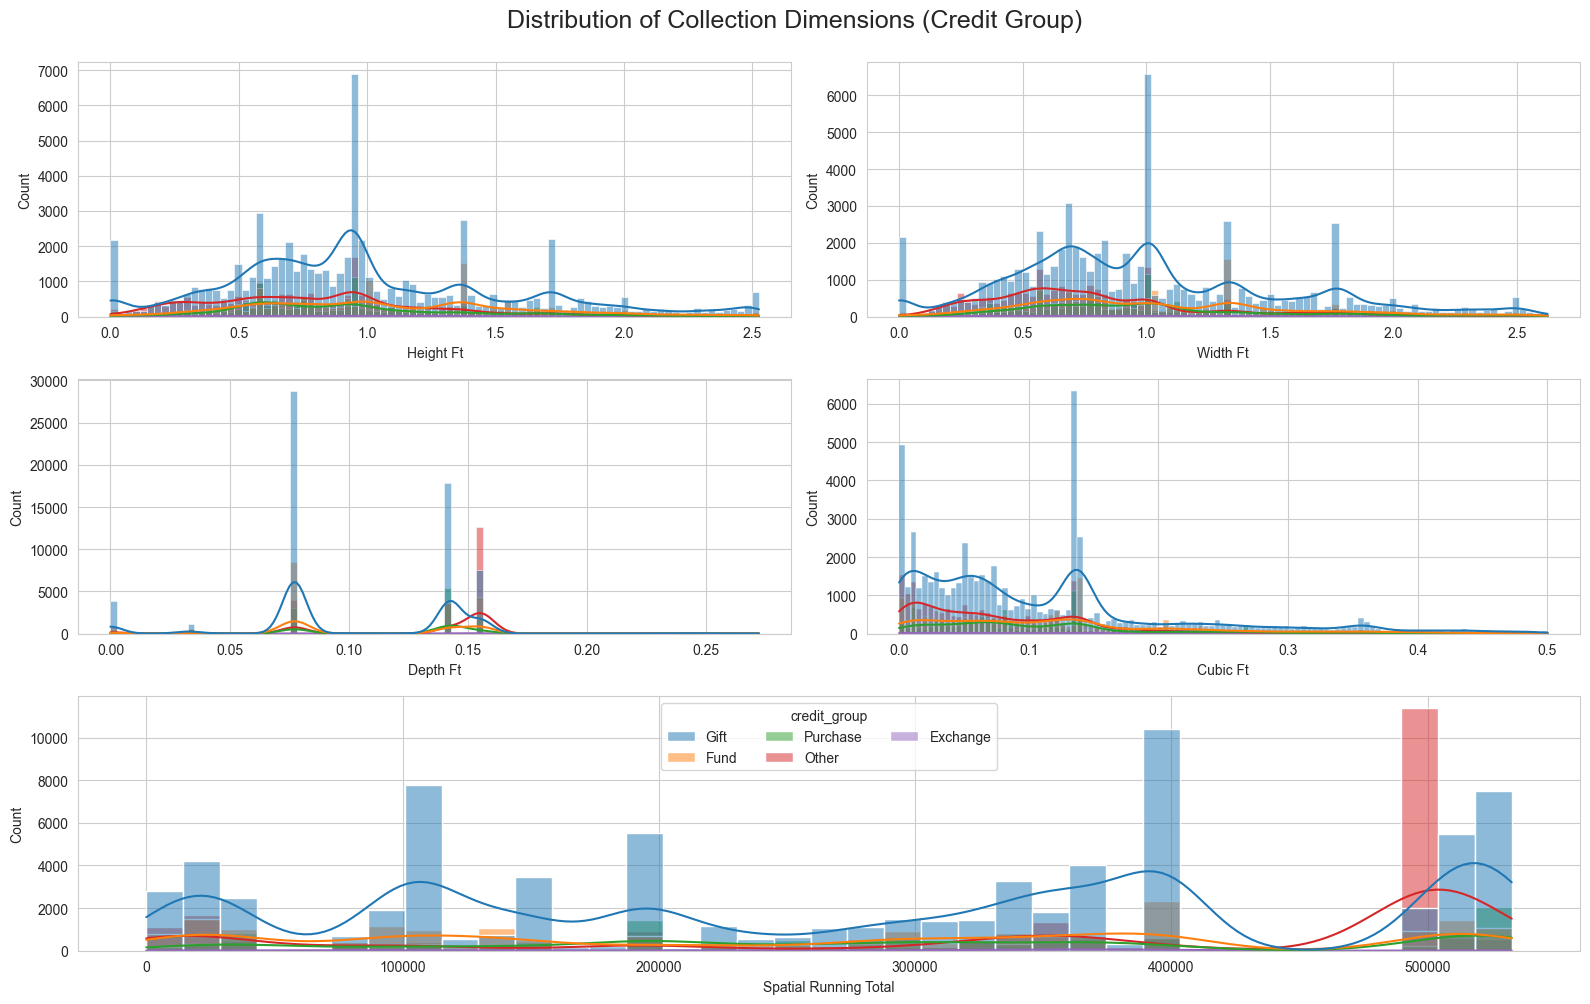

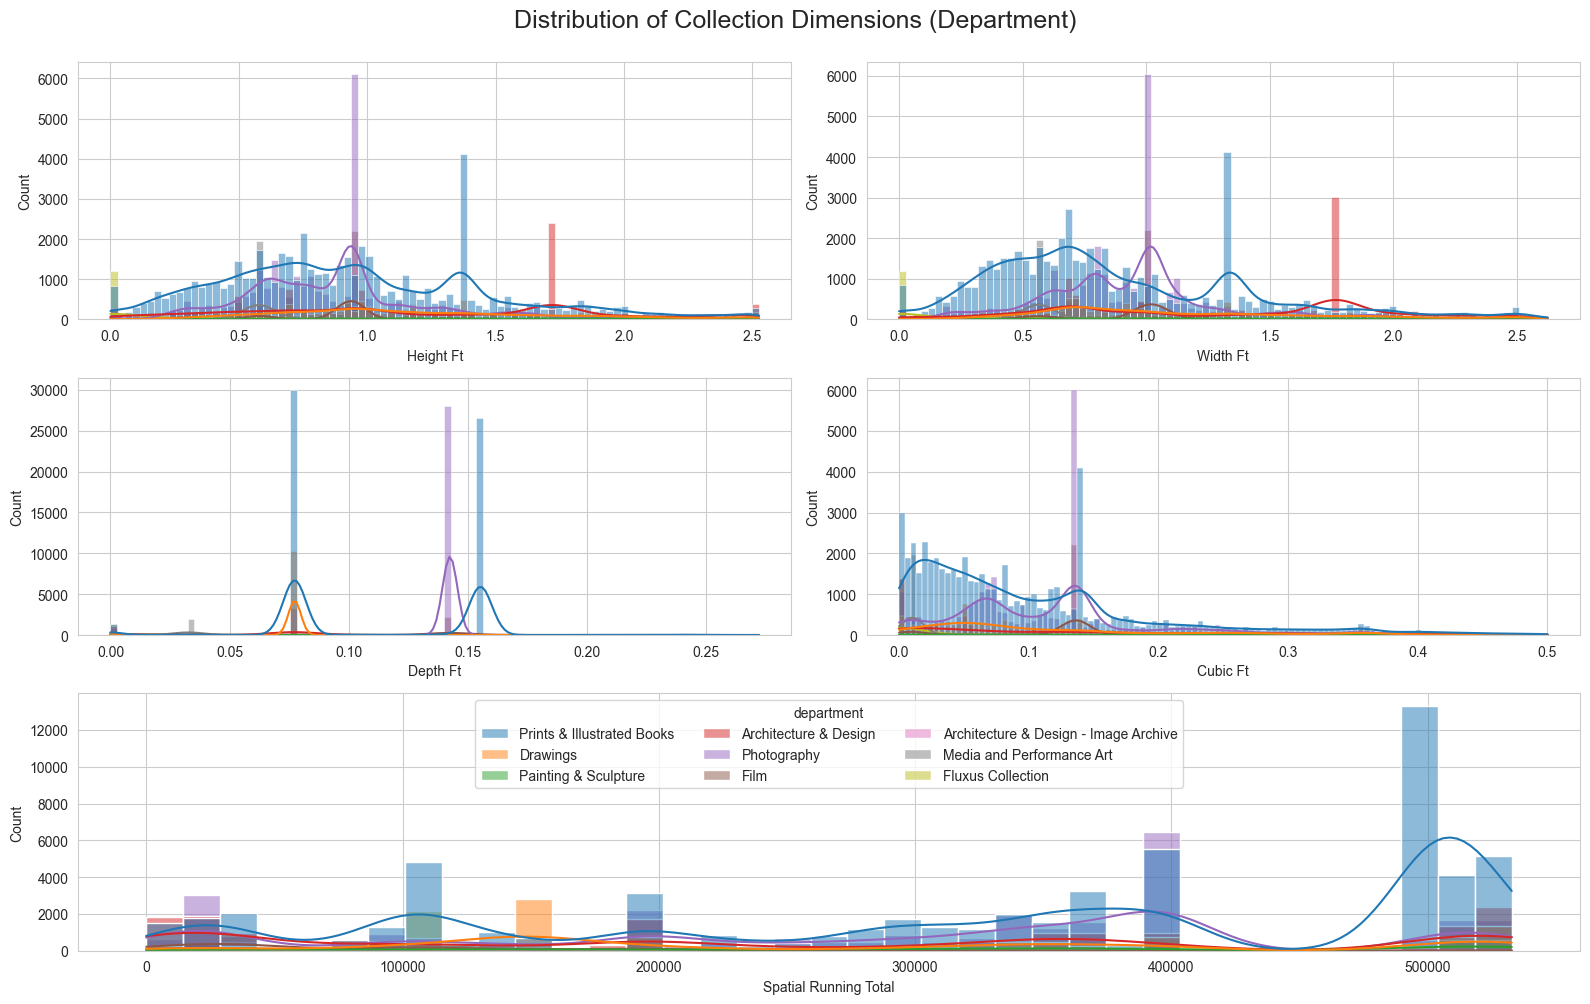

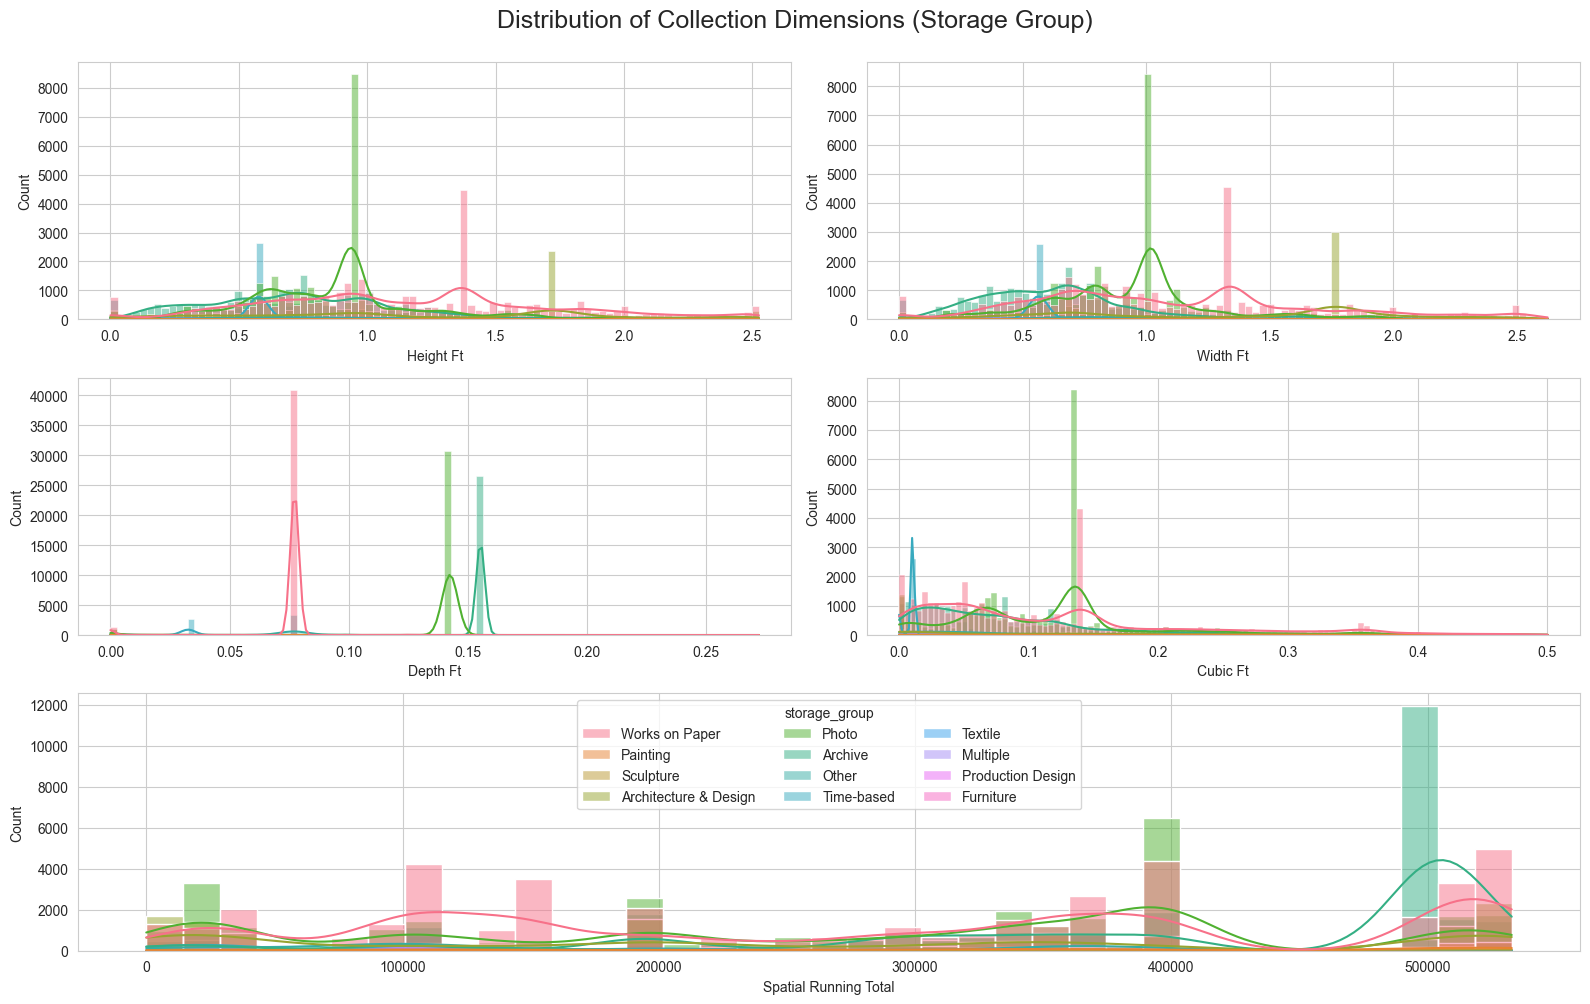

In [172]:
for category in hue_categories:
    fig, axs = plt.subplots(3, 2, figsize=(16, 10))
    plt.suptitle(f"Distribution of Collection Dimensions ({category.title().replace('_', ' ')})", fontsize = 18, y = 1.0)

    for i, column in enumerate(spatial_columns[:-1]):
        ax = axs[i // 2, i % 2]  # Calculate row and column index
        sns.histplot(data=datasets["artworks_data"], 
                     x = column, hue = category,
                     ax = ax, kde = True, legend = False)
        ax.set_xlabel(column.title().replace("_", " "))
    axs[2, 1].remove()
    axs[2, 0].remove()
    
    combined_ax = fig.add_subplot(3, 1, 3)
    sns.histplot(data = datasets["artworks_data"], x = "spatial_running_total", hue = category, ax = combined_ax, kde = True)
    sns.move_legend(combined_ax, loc = "upper center", ncol = 3)
    combined_ax.set_xlabel("spatial running total".title())
    plt.tight_layout()
    plt.show()
    plt.close(fig)


In [173]:
# Spatial totals by department and storage group
# fig, axs = plt.subplots(3, 2, figsize=(16, 10))
# data = datasets["artworks_data"].groupby("department").sum()
# plt.suptitle(f"Totals of Collection Dimensions ({category.title().replace('_', ' ')})", fontsize = 18, y = 1.0)

# for i, column in enumerate(spatial_columns[:-1]):
#     for idx, column in enumerate(spatial_columns, 1):
#         ax = axs[i // 2, i % 2]  # Calculate row and column index
#         # Acquistion date counts
#         # plt.subplot(4, 1, idx)
#         sns.countplot(
#             y = column,
#             data = data,
#             # sorts plots by descending order for visual clarity
#             # order = datasets["artworks_data"][column].sum(),
#             color = sns.color_palette("deep")[0]
#         )
#         plt.title(f"Intake Counts by {category.replace('_', ' ').title()}")
# plt.tight_layout()
# plt.show()

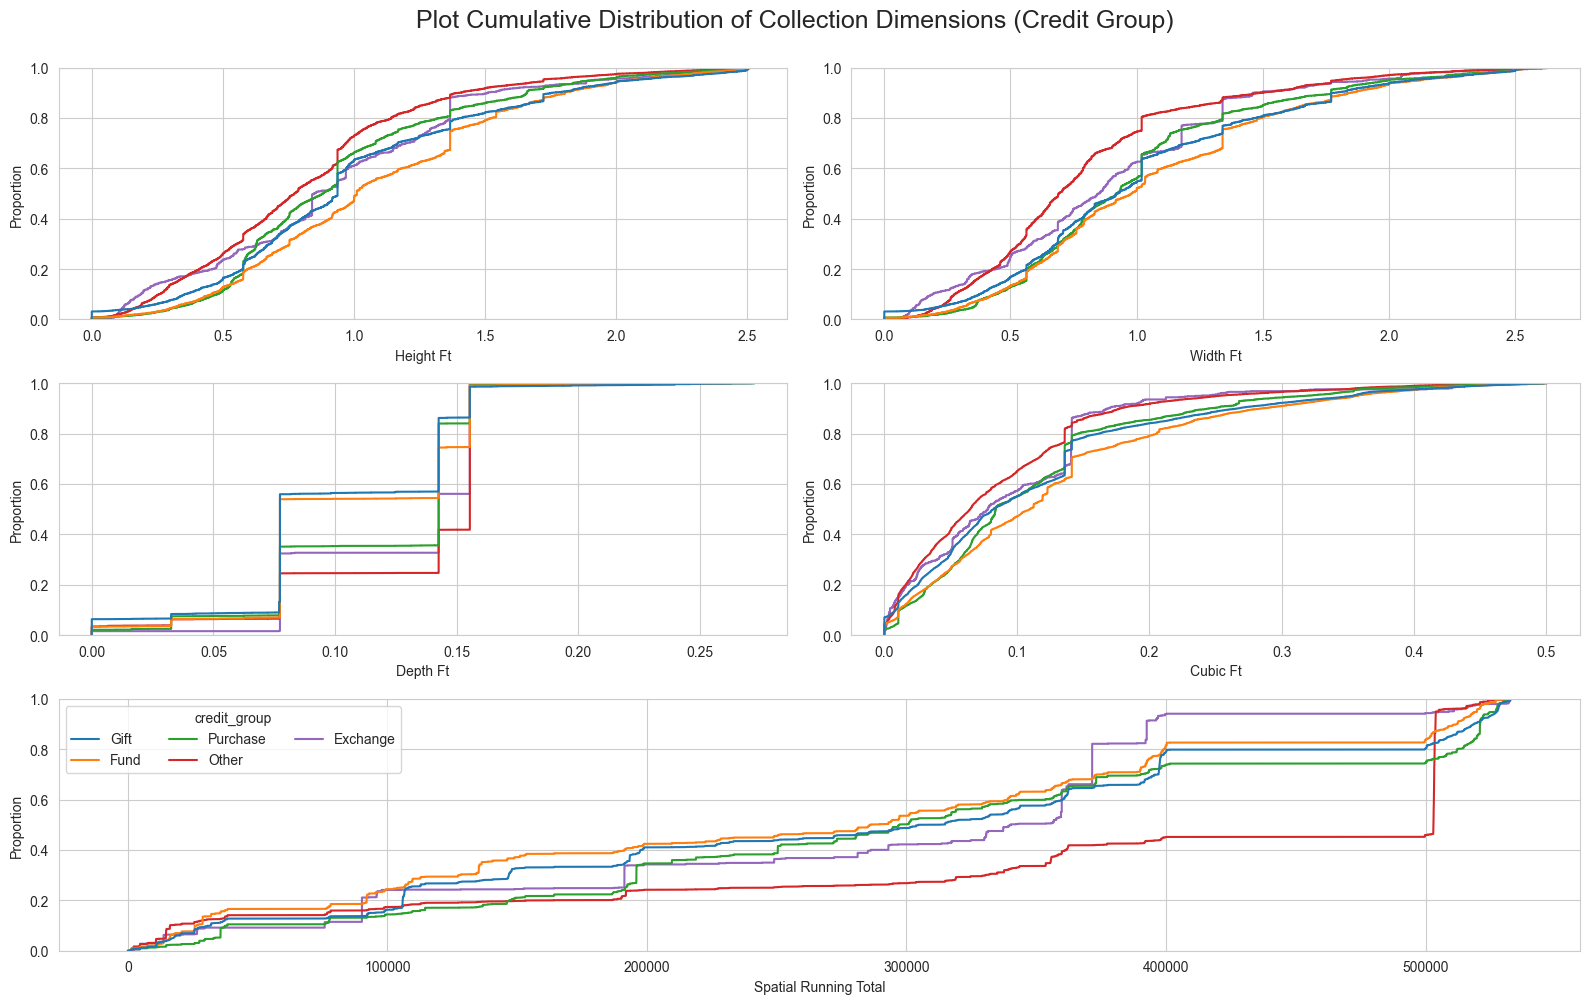

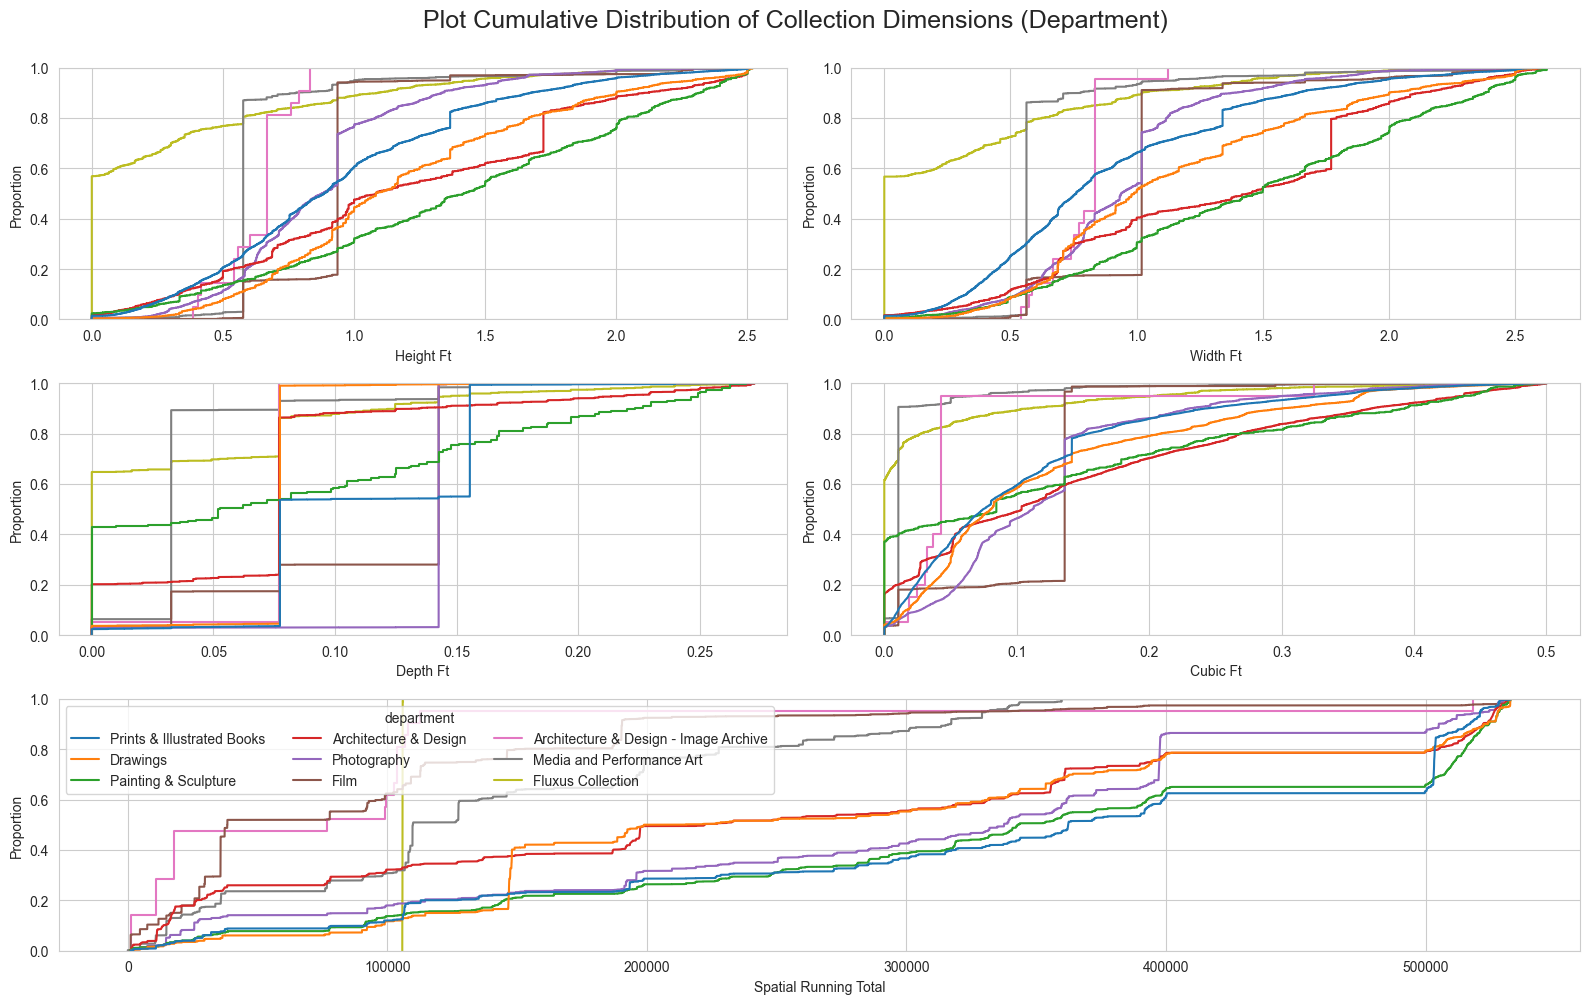

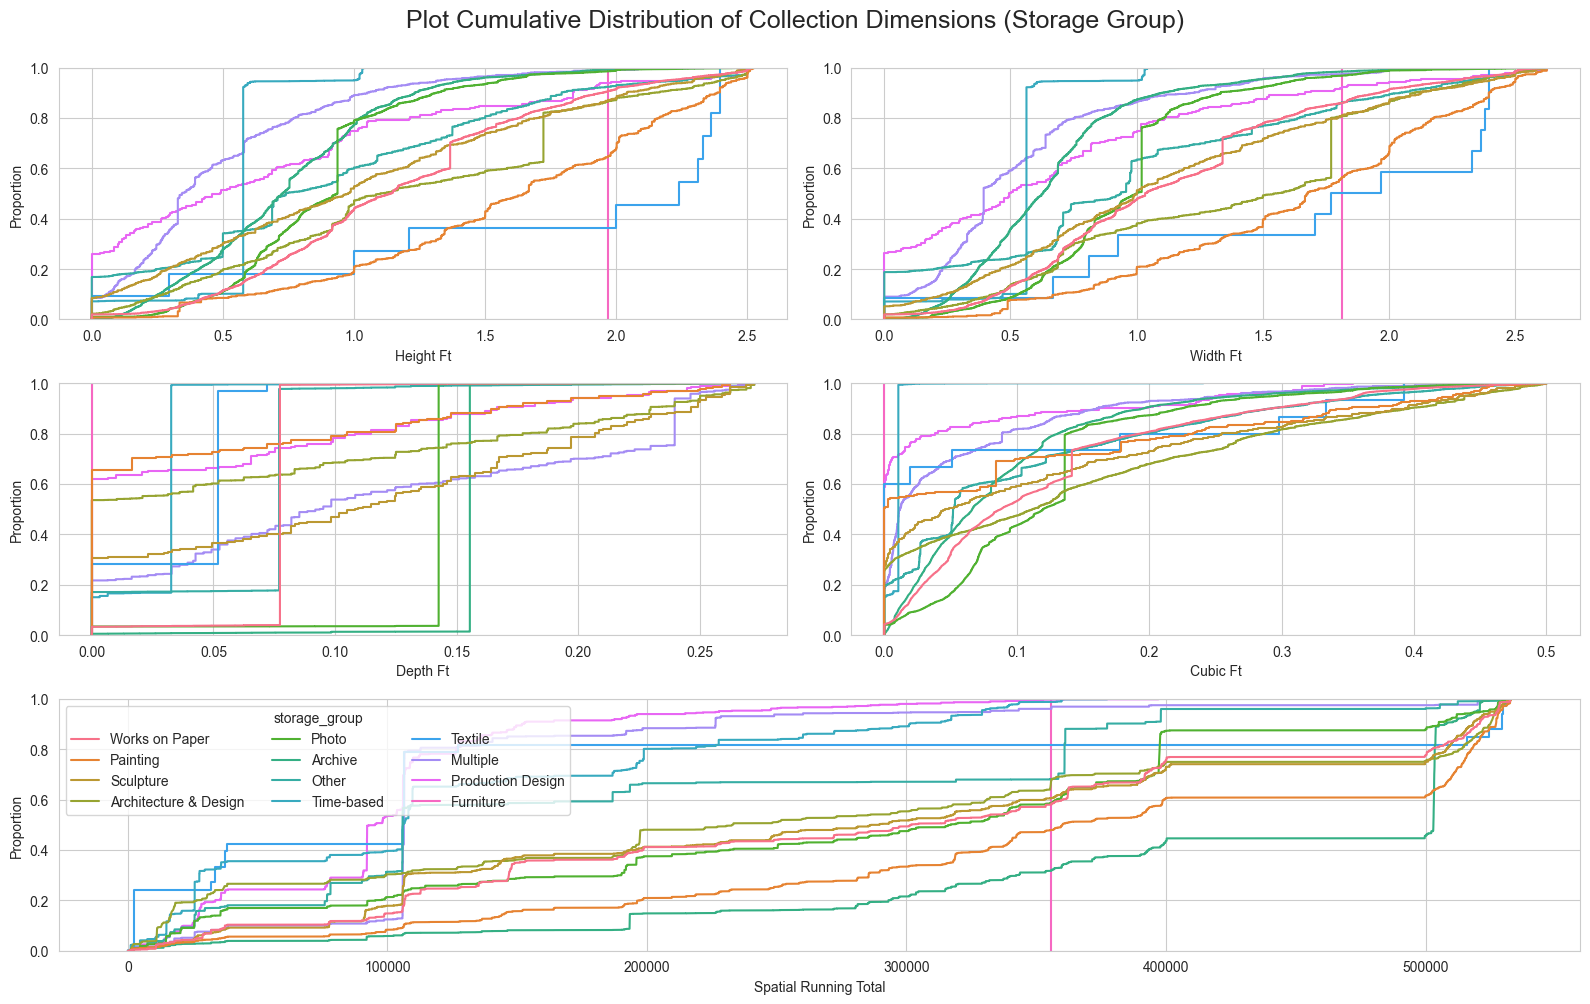

In [174]:
for category in hue_categories:
    fig, axs = plt.subplots(3, 2, figsize=(16, 10))
    plt.suptitle(f"Plot Cumulative Distribution of Collection Dimensions ({category.title().replace('_', ' ')})", fontsize = 18, y = 1.0)

    for i, column in enumerate(spatial_columns[:-1]):
        ax = axs[i // 2, i % 2]  # Calculate row and column index
        sns.ecdfplot(data=datasets["artworks_data"], 
                     x = column, hue = category,
                     ax = ax, legend = False)
        ax.set_xlabel(column.title().replace("_", " "))
    axs[2, 1].remove()
    axs[2, 0].remove()
    
    combined_ax = fig.add_subplot(3, 1, 3)
    sns.ecdfplot(data = datasets["artworks_data"], x = "spatial_running_total", hue = category, ax = combined_ax)
    combined_ax.set_xlabel("spatial running total".title())
    sns.move_legend(combined_ax, loc = "upper left", ncol = 3)
    plt.tight_layout()
    plt.show()
    plt.close(fig)

In [175]:
(datasets["artworks_data"]
 .groupby("department")
 .describe()  # Descriptive Statistics Table by Department
 .T  # Transpose for a nice view
 )

department               Architecture & Design  \
date      count                          17856   
          mean   1951-01-10 04:04:21.290322560   
          min              1768-01-01 00:00:00   
          25%              1930-01-01 00:00:00   
          50%              1949-01-01 00:00:00   
...                                        ...   
adate_sum 25%                           91.000   
          50%                          213.000   
          75%                          453.000   
          max                         1641.000   
          std                          279.366   

department      Architecture & Design - Image Archive  \
date      count                                    21   
          mean          1936-12-31 19:25:42.857142912   
          min                     1926-01-01 00:00:00   
          25%                     1930-01-01 00:00:00   
          50%                     1933-01-01 00:00:00   
...                                               ...   
adate_sum 25%                                 126.000   
          50%                                 250.000   
          75%                                 348.000   
          max                                 849.000   
          std                                 278.493   

department                            Drawings                           Film  \
date      count                          10761                           2819   
          mean   1967-12-06 02:10:28.268748248  1974-03-17 13:25:03.086200784   
          min              1865-01-01 00:00:00            1895-01-01 00:00:00   
          25%              1945-01-01 00:00:00            1957-01-01 00:00:00   
          50%              1971-01-01 00:00:00            1977-01-01 00:00:00   
...                                        ...                            ...   
adate_sum 25%                           43.000                         20.750   
          50%                          110.000                         86.000   
          75%                          171.000                        193.000   
          max                         1484.000                        698.000   
          std                          169.174                        173.579   

department                   Fluxus Collection      Media and Performance Art  \
date      count                            935                           2597   
          mean   1968-06-13 20:38:14.759358288  1987-05-12 21:39:42.903350016   
          min              1946-01-01 00:00:00            1958-01-01 00:00:00   
          25%              1964-01-01 00:00:00            1976-01-01 00:00:00   
          50%              1966-01-01 00:00:00            1986-01-01 00:00:00   
...                                        ...                            ...   
adate_sum 25%                              NaN                         14.000   
          50%                              NaN                         61.000   
          75%                              NaN                        143.000   
          max                              NaN                        556.000   
          std                              NaN                        110.947   

department                Painting & Sculpture                    Photography  \
date      count                           3797                          28817   
          mean   1958-04-24 09:27:21.190413504  1939-02-21 10:02:32.659888384   
          min              1872-01-01 00:00:00            1786-01-01 00:00:00   
          25%              1940-01-01 00:00:00            1911-01-01 00:00:00   
          50%              1961-01-01 00:00:00            1939-01-01 00:00:00   
...                                        ...                            ...   
adate_sum 25%                           11.000                         91.000   
          50%                           27.000                        175.000   
          75%                          

In [176]:
(datasets["artworks_data"]
 .groupby("storage_group")
 .describe()  # Descriptive Statistics Table by Storage Group / Type
 .T  # Transpose for a nice view
 )

storage_group            Architecture & Design                        Archive  \
date      count                          14552                          26933   
          mean   1954-05-17 21:26:25.266630080  1944-02-11 02:02:03.773809152   
          min              1768-01-01 00:00:00            1797-01-01 00:00:00   
          25%              1931-01-01 00:00:00            1925-01-01 00:00:00   
          50%              1957-01-01 00:00:00            1945-01-01 00:00:00   
...                                        ...                            ...   
adate_sum 25%                           83.000                        165.000   
          50%                          172.000                        306.000   
          75%                          453.000                        453.000   
          max                         1641.000                       1692.000   
          std                          272.150                        478.739   

storage_group              Furniture                       Multiple  \
date      count                    1                            979   
          mean   1913-01-01 00:00:00  1976-07-19 00:02:56.506639424   
          min    1913-01-01 00:00:00            1942-01-01 00:00:00   
          25%    1913-01-01 00:00:00            1965-01-01 00:00:00   
          50%    1913-01-01 00:00:00            1969-01-01 00:00:00   
...                              ...                            ...   
adate_sum 25%                803.000                        102.000   
          50%                803.000                        250.000   
          75%                803.000                        371.000   
          max                803.000                        803.000   
          std                    NaN                        228.688   

storage_group                            Other                       Painting  \
date      count                           3692                           2260   
          mean   1939-08-05 21:38:48.494041088  1953-06-27 10:05:18.584070784   
          min              1910-01-01 00:00:00            1872-01-01 00:00:00   
          25%              1930-01-01 00:00:00            1933-01-01 00:00:00   
          50%              1934-01-01 00:00:00            1956-01-01 00:00:00   
...                                        ...                            ...   
adate_sum 25%                          176.000                         11.000   
          50%                          294.000                         30.000   
          75%                          820.000                        103.000   
          max                         1159.000                       1484.000   
          std                          292.670                        163.533   

storage_group                            Photo              Production Design  \
date      count                          31571                            535   
          mean   1942-02-22 05:41:29.588546432  1997-10-27 21:58:52.710280320   
          min              1786-01-01 00:00:00            1948-01-01 00:00:00   
          25%              1913-01-01 00:00:00            1992-01-01 00:00:00   
          50%              1945-01-01 00:00:00            2005-01-01 00:00:00   
...                                        ...                            ...   
adate_sum 25%                           87.000                         22.000   
          50%                          167.000                         78.000   
          75%                          363.000                        111.000   
          max                         1484.000                        670.000   
          std                          271.441                         95.988   

storage_group                        Sculpture                        Textile  \
date      count                           1624                             31   
          mean   1963-11-16 06:15:04.433497536  1978-02-28 20:54:1

In [177]:
(datasets["artworks_data"]
 .groupby("credit_group")
 .describe()  # Descriptive Statistics Table by Credit Group
 .T  # Transpose for a nice view
 )

credit_group                          Exchange                           Fund  \
date      count                            824                          19484   
          mean   1940-02-11 09:19:13.398058240  1969-10-13 21:32:06.750153956   
          min              1850-01-01 00:00:00            1840-01-01 00:00:00   
          25%              1917-01-01 00:00:00            1958-01-01 00:00:00   
          50%              1946-01-01 00:00:00            1972-01-01 00:00:00   
...                                        ...                            ...   
adate_sum 25%                           93.000                        103.000   
          50%                          124.000                        200.000   
          75%                          322.000                        361.000   
          max                         1692.000                       1692.000   
          std                          164.408                        219.638   

credit_group                              Gift                          Other  \
date      count                          71739                          22432   
          mean   1955-08-27 07:40:05.269100544  1936-10-12 16:21:43.138373760   
          min              1768-01-01 00:00:00            1786-01-01 00:00:00   
          25%              1930-01-01 00:00:00            1921-01-01 00:00:00   
          50%              1963-01-01 00:00:00            1936-01-01 00:00:00   
...                                        ...                            ...   
adate_sum 25%                          100.000                        104.500   
          50%                          207.000                        244.000   
          75%                          460.000                        481.000   
          max                         1692.000                       1692.000   
          std                          423.854                        366.241   

credit_group                          Purchase  
date      count                          12331  
          mean   1956-06-19 22:57:03.371989184  
          min              1808-01-01 00:00:00  
          25%              1937-01-01 00:00:00  
          50%              1963-01-01 00:00:00  
...                                        ...  
adate_sum 25%                           82.000  
          50%                          147.000  
          75%                          353.000  
          max                         1692.000  
          std                          309.612  

[64 rows x 5 columns]

In [199]:
(datasets["recent_tsdata"].to_csv("NYC-MoMA-Recent-Collections_TS.csv"))

## Conclusions & Recommendations

I will add thinking for how to go about forecasting given our analysis. All of that will be added in this section, which doubles as a high-level overview of the forecasting approach.

Models in consideration:
Naive Forecast, MA, ES, CROSTON, SBA, TBS

Why:
Given that our professional working assumption is that our data as accession-only and accessions counts cannot go below zero, it's necessary to model the data as a "Intermittent Demand-side Forecasting" problem. Borrowing from the field of predictive inventory analytics, this approach allows us to model influxes of objects in a collection without necessitating deaccession data to make predictions about collections growth. In live projects with MMM clients, we anticipate having more flexibility in our model selection processes (because we're not actually working with the MoMA, just their data). As the stand-in for our collections professional client, Samantha, had put forward that they would like to understand any hierarchical relationships within the dataset such as object counts by department and storage group as they filter up to inform the overall total of incoming works.  

What:
For our forecasting process, we will be comparing a couple of standard statistical models to more specified predictive techniques. The client's desired analysis outcomes indicate to me that we will be prioritizing bottom-up hierarchical models which have been designed to perform well in predicting intermittent, incoming quantities. Each of the statistical models have accompanying metrics which describe various aspects of their predictive performance, for the purposes of this demonstration analysis we will be using the following metrics: MSE, RMSE, MAD, etc.